In [1]:
import sys
import os

# adding custom alignment module to path
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment

# tracking algorithms for comparison
from laptrack import LapTrack # for comparison to Trackmate (default is a LAP tracker)
import trackpy as tp # alternative to Trackmate
#import btrack

# custom alignment module
from align_spheroid.alignment import convert_raw_to_long
from align_spheroid import CellSimulator, Aligner2D
from align_spheroid.evaluation import (
    compare_paths, procrustes_distance, hausdorff_distance, earth_movers_distance, 
    frechet_distance, relative_movement, normalize_distance, distance_matrix_error,
    alignment_accuracy, build_long_true, calc_accuracy
)

import copy
from collections import namedtuple
from tqdm import tqdm
import contextlib
import io

# Comparison of Global Tracking Algorithms to Custom Alignment Algorithm

## Helper Function

In [3]:
# function to convert a simulated data set from wide to long
# stacks the labels vertically to keep track of "true" label predictions
def build_long_true(data, n, timepoints):
    x_cols = [c for c in data.columns if "x" in c]
    y_cols = [c for c in data.columns if "y" in c]
    label_cols = [c for c in data.columns if "label" in c]
    
    xvals = data[x_cols].values.T.ravel()
    yvals = data[y_cols].values.T.ravel()
    tplabels = data[label_cols].values.T.ravel()
    tps = [j for subl in [[i]*n for i in timepoints] for j in subl]
    
    long_true = pd.DataFrame({
        'true_label':tplabels,
        'timepoint':tps,
        'raw_x':xvals,
        'raw_y':yvals
    })
    return long_true

def calc_accuracy(series1: pd.Series, series2: pd.Series) -> int:
    """
    Counts the number of element-wise matches between two pandas Series.

    Parameters:
    - series1 (pd.Series): First series.
    - series2 (pd.Series): Second series.

    Returns:
    - int: Number of matching elements.
    """
    if len(series1) != len(series2):
        raise ValueError("Both Series must be of the same length.")
    
    # Create boolean mask where neither value is NaN
    valid_mask = ~series1.isna() & ~series2.isna()
    
    # Count matches only where both values are not NaN
    return (series1[valid_mask] == series2[valid_mask]).sum()/len(series1)*100

In [4]:
SimResult = namedtuple('SimResult', ['accuracy_df', 'sim_data', 'sim_data_long', 'tracks_df', 'linked_df', 'tp', 'aligner'])

## Simulated Data Used in Figure 2 of Manuscript

In [5]:
# simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6

# Re-load CSV file
csv_path = "../../synthetic_data/fig2_synthetic_data_wide_seed42.csv"
df = pd.read_csv(csv_path)
df.rename(columns={ df.columns[0]: "label_0h" }, inplace = True)
df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])
simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

In [6]:
df

,label_assumed,label_0h,x_0h,y_0h,label_24h,x_24h,y_24h,label_48h,x_48h,y_48h,label_72h,x_72h,y_72h,label_168h,x_168h,y_168h
0,a,a,847.386701,617.106208,e,744.186425,432.478472,c,424.829563,336.264961,d,148.533880,646.271067,b,546.599861,154.539051
1,b,b,766.601093,453.260128,a,679.303770,176.964891,e,317.271871,710.166499,c,352.620304,494.456000,a,722.544376,108.947110
2,c,c,280.699932,543.886169,c,523.577253,735.873475,a,480.051562,913.039042,f,295.169116,861.048470,f,938.848775,619.041118
3,d,d,144.074881,767.347036,d,717.426078,896.738381,f,102.170741,519.369774,e,578.661699,802.883568,d,789.263542,820.767669
4,e,e,607.174821,710.083420,b,505.401598,224.331378,d,174.068543,264.912825,b,850.792129,635.641368,c,574.140139,688.593212
5,f,f,380.711294,885.972380,f,876.779807,684.275994,b,623.980052,796.625568,a,844.666507,815.668001,e,799.609519,355.987554


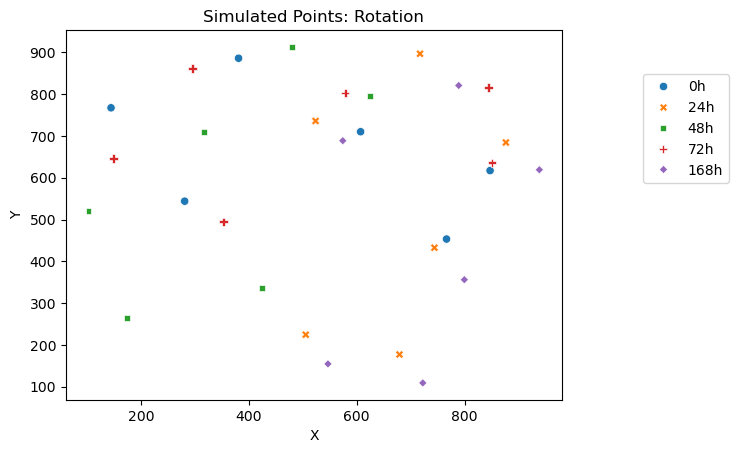

In [7]:
simulated_data_long = convert_raw_to_long(df, point_name='label_0h')

# Plot all points in the "well"
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    data = simulated_data_long,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'Timepoint', #'Original Point Name', 
    style = 'Timepoint',
    ax=ax
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Simulated Points: Rotation')
leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
plt.show()
plt.close()

In [8]:
# load the long form of the simulated data with the true point/spheroid labels
simulated_data_long = pd.read_csv("../../synthetic_data/fig2_synthetic_data_long_seed42.csv")

### LAP Tracking (Trackmate) Algorithm
The default setting for TrackMate is the Simple LAP tracker (see [documentation](https://imagej.net/plugins/trackmate/trackers/lap-trackers)). The TrackMate GUI does not enable tracking based on particle centroid motion alone, and requires the images of the particles. Here we will test the "tracking" or alignment performance on the simulated data set using the LAP tracking algorithm implemented in Python.

In [9]:
# Step 1: Map timepoint strings to frame numbers
timepoint_order = ['0h', '24h', '48h', '72h', '168h']
timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
simulated_data_long['frame'] = simulated_data_long['timepoint'].map(timepoint_to_frame)

In [10]:
# Step 2: Rename coordinate columns
simulated_data_long = simulated_data_long.rename(columns={'raw_x': 'x', 'raw_y': 'y'})

In [11]:
# Step 3: Apply LapTrack
tracker = LapTrack()
tracks_df, links_df, _ = tracker.predict_dataframe(
    simulated_data_long, 
    coordinate_cols=['x', 'y'],
    only_coordinate_cols=True
)

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/laptrack/_tracking.py:808: FutureWarning: The parameter only_coordinate_cols will be False by default in the major release.
  warnings.warn(


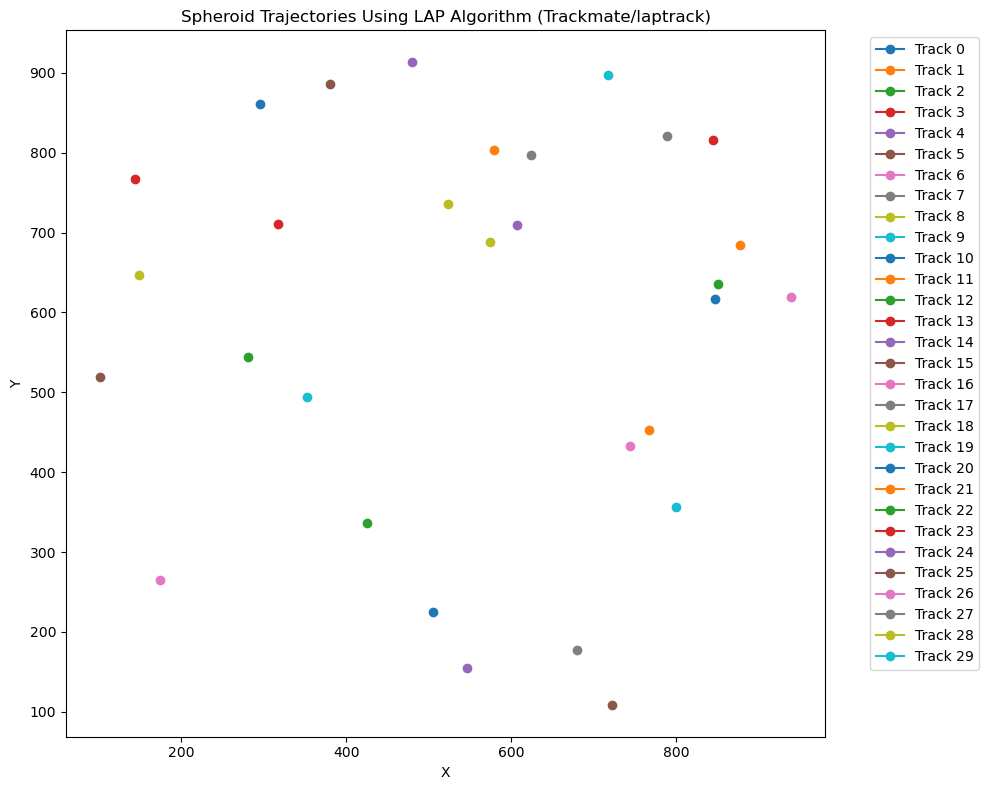

In [12]:
# Assumes `tracks_df` contains columns: 'x', 'y', 'frame', 'track_id'
plt.figure(figsize=(10, 8))

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    plt.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spheroid Trajectories Using LAP Algorithm (Trackmate/laptrack)')
#plt.gca().invert_yaxis()  # Optional: invert Y-axis to match microscope convention
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

In [14]:
# Merge predicted and ground truth data
df_long = simulated_data_long.copy()
#df_long['frame'] = df_long['Timepoint'].map(timepoint_to_frame)
#df_long = df_long.rename(columns={'raw_x': 'x', 'raw_y': 'y'})
df_merged = tracks_df.merge(df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y'])
track_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
df_merged['track_id_label'] = [str(i) for i in df_merged['track_id'].map(track_id_mapping)]

# Compare `track_id` (predicted) to `true_label` (ground truth)
# Map labels to integers for ARI or clustering metrics
true_labels = df_merged['true_label']
pred_labels = df_merged['track_id_label']

# Accuracy (if labels are aligned one-to-one)
# need to compare timepoints > 0 so start with frame index = 1
acc = accuracy_score(true_labels[6:], pred_labels[6:])
laptrack_accuracy = acc

# Clustering-based similarity (more robust to label permutation)
ari = adjusted_rand_score(true_labels, pred_labels)

print(f"Tracking Accuracy: {acc:.2f}")
print(f"Adjusted Rand Index: {ari:.2f}")

Tracking Accuracy: 0.00
Adjusted Rand Index: -0.02


#### LAP Tracking (Trackmate/laptrack) Results
LAP tracking identifies 30 distinct tracks across the six tumor spheroids and five timepoints, suggesting that each spheroid forms its own 'track'. After merging the tracked data frame with the baseline true data frame, we find that the LAP tracker does not correctly label any of the spheroids, resulting in an accuracy of 0% and an adjusted Rand Index of -0.02.

### Crocker-Grier Algorithm (pcnaDeep/trackpy)
The Crocker-Grier Algorithm is another method for tracking particles as they move through space over time. It was initially developed for following particles undergoing Brownian diffusion where a particle's velocity is uncorrelated from one frame to the next. Simple implemntations of this algorithm such as the one in [trackpy](https://trackpy.readthedocs.io/en/stable/) rely on following the object's centroid, which makes it a viable algorithm to compare in this scenario. Crocker-Grier has been used as the underlying basis for [deep learning based cell tracking approaches](https://academic.oup.com/bioinformatics/article/38/20/4846/6680181) that integrate higher-level features (analogous to face-matching).

In [15]:
# The `search_range` parameter defines the maximum distance a particle can move between frames
linked_df = tp.link_df(simulated_data_long, search_range=250, memory=0)

# Now `linked_df` has an additional column 'particle' which is the track ID
print(linked_df.head(12))

Frame 4: 6 trajectories present.
   true_label timepoint           x           y  frame  particle
0           a        0h  847.386701  617.106208      0         0
1           b        0h  766.601093  453.260128      0         1
2           c        0h  280.699932  543.886169      0         2
3           d        0h  144.074881  767.347036      0         3
4           e        0h  607.174821  710.083420      0         4
5           f        0h  380.711294  885.972380      0         5
6           e       24h  744.186425  432.478472      1         1
7           a       24h  679.303770  176.964891      1         6
8           c       24h  523.577253  735.873475      1         4
9           d       24h  717.426078  896.738381      1         7
10          b       24h  505.401598  224.331378      1         8
11          f       24h  876.779807  684.275994      1         0


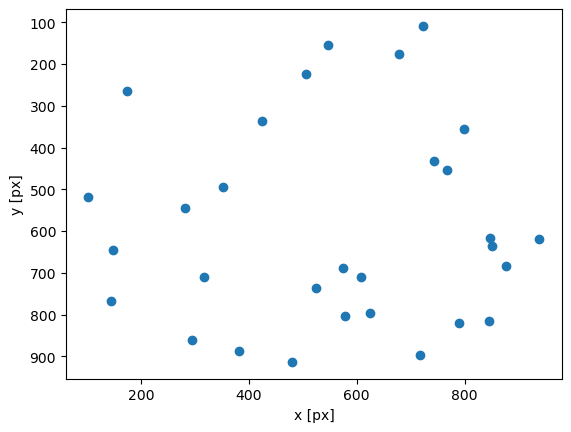

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [16]:
tp.scatter(linked_df)

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


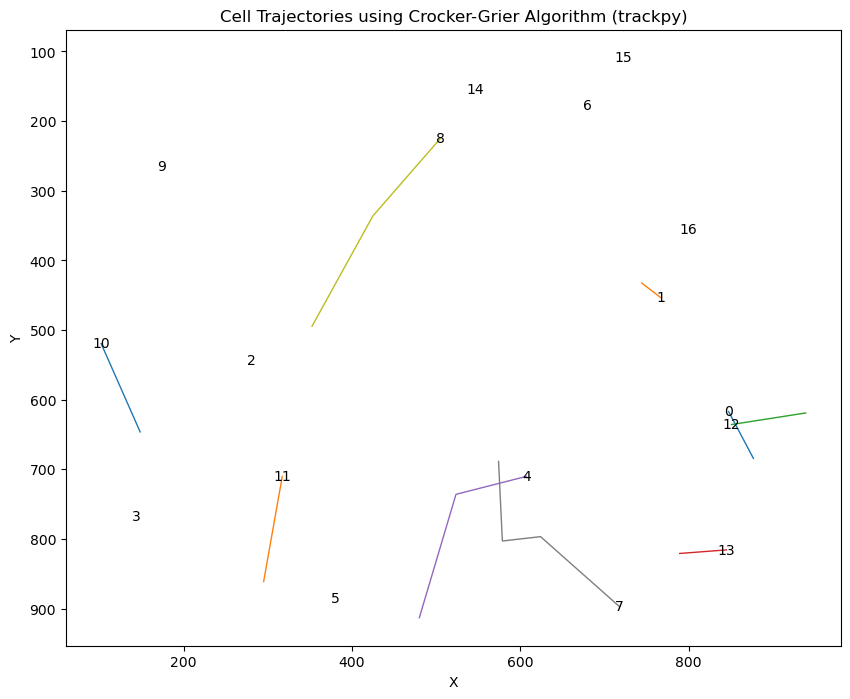

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(linked_df, label=True, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Cell Trajectories using Crocker-Grier Algorithm (trackpy)')
plt.show()

In [18]:
# Step 1: Merge trackpy and ground truth data
merged_df = pd.merge(linked_df, df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y', 'true_label'])
merged_df['particle_str'] = [str(i) for i in merged_df['particle']]

# Step 2: Compute confusion matrix
conf_mat = confusion_matrix(merged_df['true_label'], merged_df['particle_str'])

# Step 3: Hungarian algorithm for optimal label mapping
row_ind, col_ind = linear_sum_assignment(-conf_mat)
mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

# Step 4: Apply mapping
merged_df['particle_aligned'] = merged_df['particle'].map(mapping)

# Step 5: Calculate accuracy
tp_accuracy = accuracy_score(merged_df['true_label'], merged_df['particle_aligned'])

# Clustering-based similarity (more robust to label permutation)
tp_ari = adjusted_rand_score(merged_df['true_label'], merged_df['particle_aligned'])

print(f"Trackpy tracking accuracy: {tp_accuracy:.2f}")
print(f"Trackpy tracking adjusted Rand Index: {tp_ari:.2f}")

Trackpy tracking accuracy: 0.00
Trackpy tracking adjusted Rand Index: -0.04


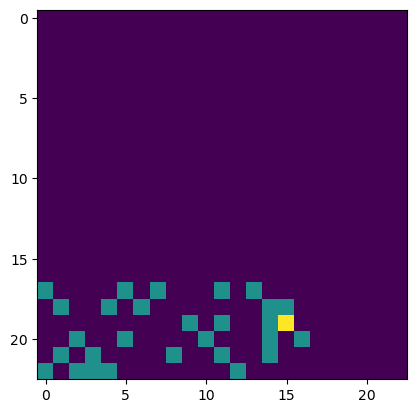

In [19]:
plt.imshow(conf_mat)

#### Crocker-Grier (pcnaDeep) Results
Crocker-Grier tracking identifies 16 distinct tracks across the six tumor spheroids and five timepoints. Several of the tracks link the wrong spheroids together to form a track while others are labeled as single instances (no trajectory). After merging the tracked data frame with the baseline true data frame, we find that the trackpy tracker does not correctly label any of the spheroids, resulting in an accuracy of 0% and an adjusted Rand Index of -0.04.

### Procrustes Alignment (proposed algorithm or "TRACE-QC")

In [20]:
# prep the data for alignment
dataX = df[[col for col in df.columns if 'x' in col]].values #transpose
dataY = df[[col for col in df.columns if 'y' in col]].values #transpose

# Create an Aligner2D instance
aligner = Aligner2D(well_name="Simulated Data", time_points=timepoints)

# get the labels to use for the alignment
labels = list(df.label_0h)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

n_circles = len(np.unique(df.label_0h))
timepoints = ['0h', '24h', '48h', '72h', '168h']
simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

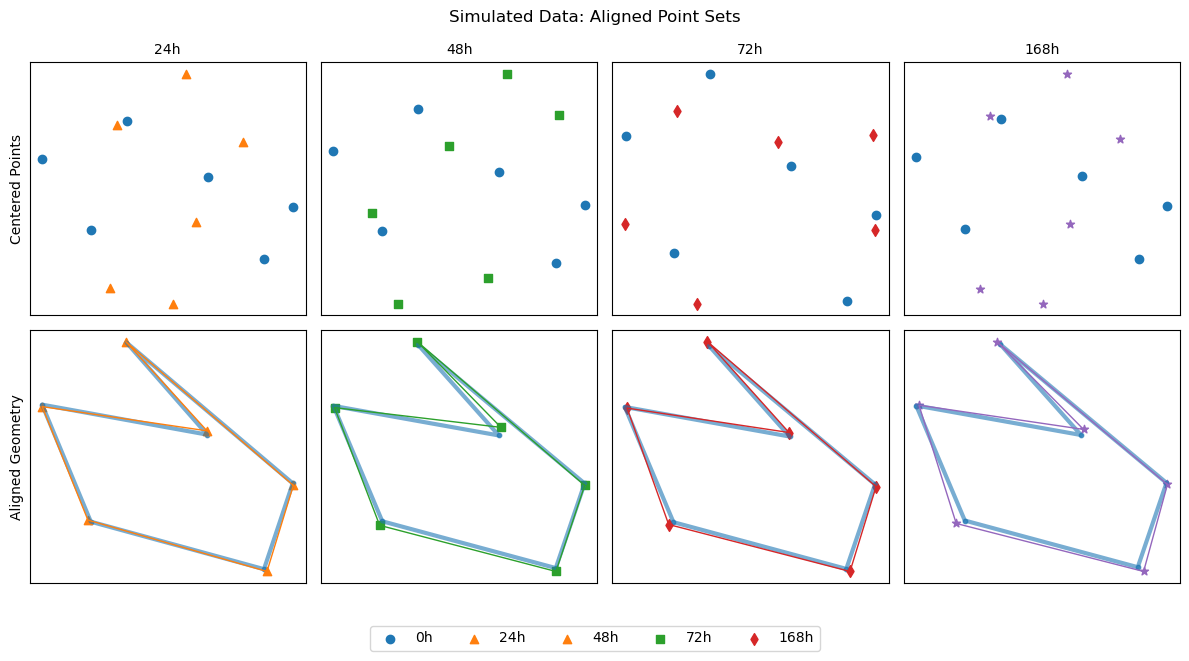

<Figure size 640x480 with 0 Axes>

In [21]:
# plotting
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, save=False, show_plot=True)#, save_dir='plots', )  # Pass fig and axs
#fig.savefig(os.path.join(out_dir, "rotation_translation_mpjitter_alignment.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [30]:
tracqc_acc = calc_accuracy(
    pd.Series(simulated_data_long_true['true_label'].values.astype(str))[6:], 
    pd.Series(aligner.registered_df['aligned_label'].values.astype(str))[6:]
)
print(f"Accuracy: {tracqc_acc}")

Accuracy: 100.0


### Overall Tracking Accuracy Figure

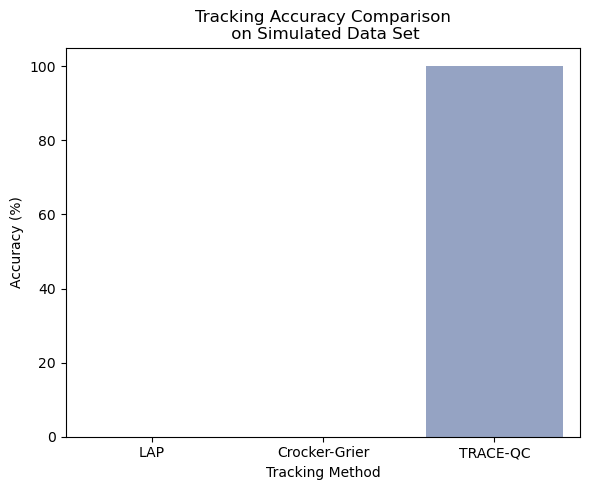

In [31]:
# Assume you already calculated these:
# - laptrack_accuracy: accuracy from LapTrack (float)
# - tp_accuracy: accuracy from Trackpy (float)

# Step 1: Create a DataFrame with results
# Step 1: Create a DataFrame with results
accuracy_df = pd.DataFrame({
    'Tracker': ['LAP', 'Crocker-Grier', 'TRACE-QC'],
    'Accuracy': [laptrack_accuracy, tp_accuracy, tracqc_acc]
})

# Step 2: Plot
plt.figure(figsize=(6, 5))
sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2')
plt.ylim(0, 105)
plt.title('Tracking Accuracy Comparison\n on Simulated Data Set')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tracking Method')
plt.tight_layout()
plt.show()

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_79281/2167612336.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


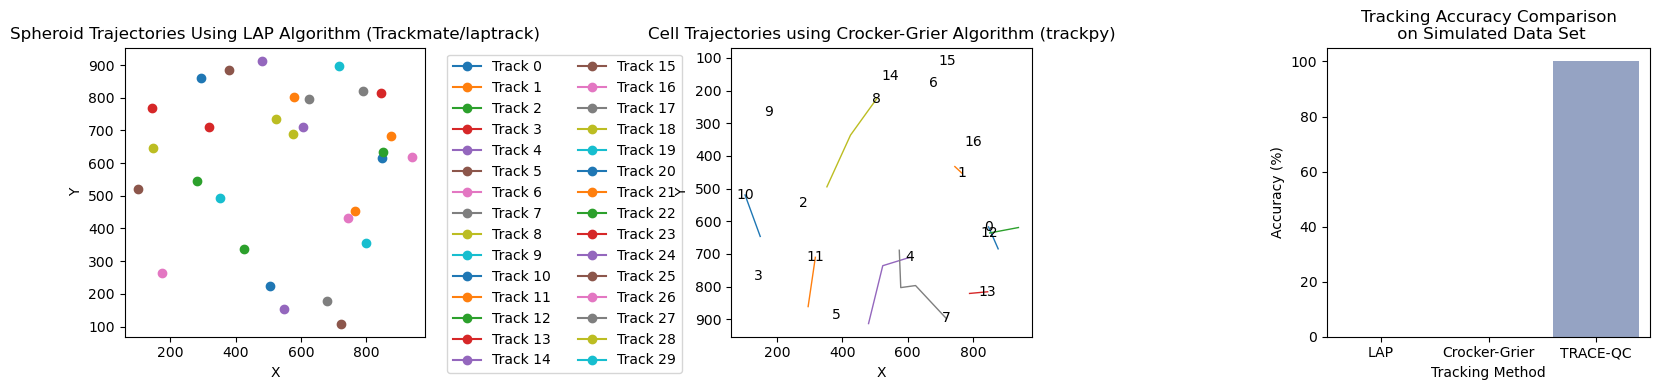

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
ax = ax.ravel()

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    ax[0].plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Spheroid Trajectories Using LAP Algorithm (Trackmate/laptrack)')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax[0].set_aspect('equal')

tp.plot_traj(linked_df, label=True, ax=ax[1])
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('Cell Trajectories using Crocker-Grier Algorithm (trackpy)')
ax[1].set_aspect('equal')

sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2', ax=ax[2])
ax[2].set_ylim(0, 105)
ax[2].set_title('Tracking Accuracy Comparison\n on Simulated Data Set')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_xlabel('Tracking Method')
#ax[2].set_aspect('equal')

plt.tight_layout()
plt.show()
plt.close()

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


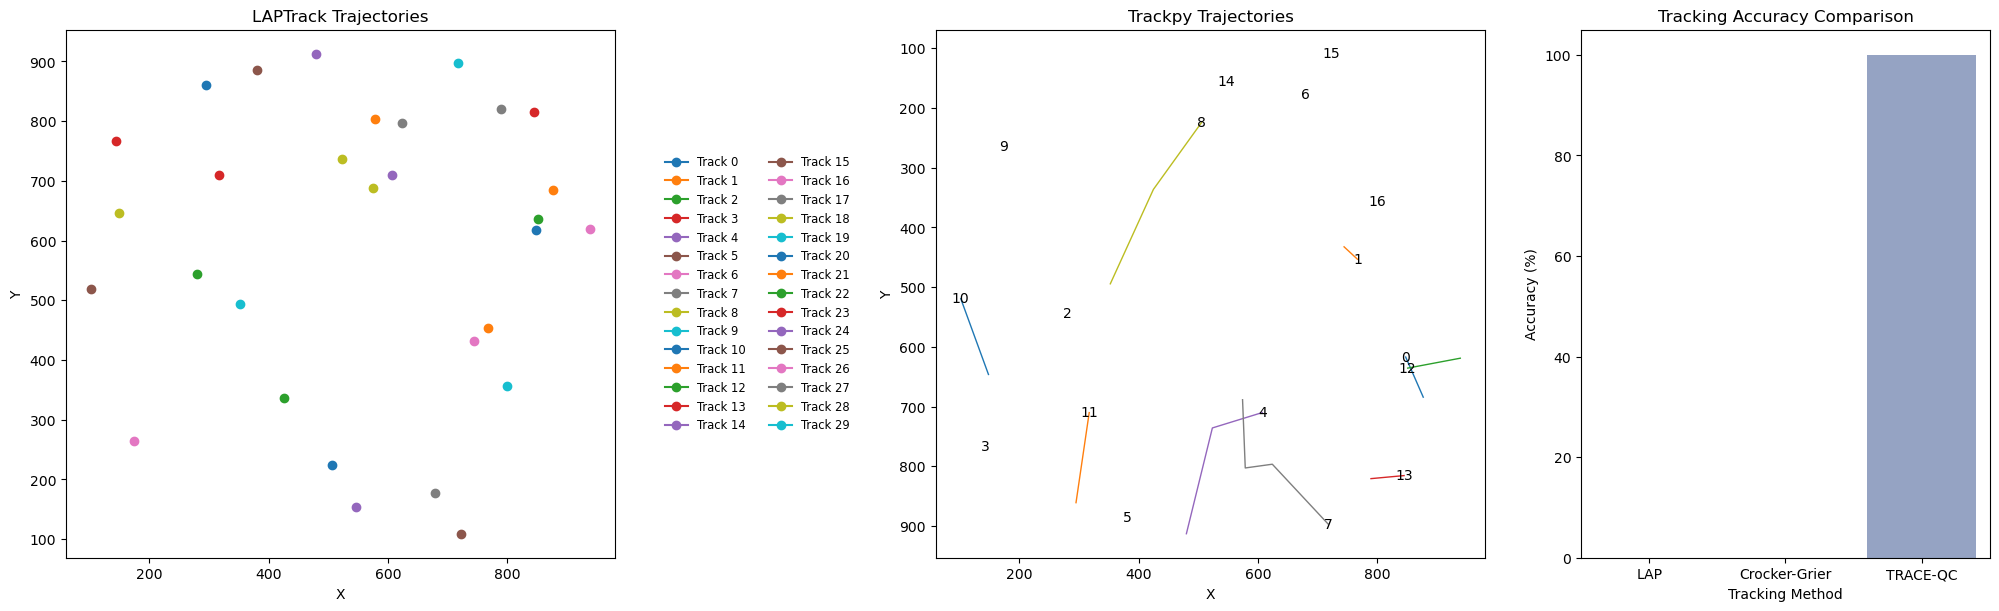

In [33]:
# Define the layout (e.g. 10 columns total: 3 + 1 + 3 + 3)
layout = """
AAABCCCDD
"""

# Define matching width ratios: A=3, B=1 (legend), C=3, D=3
fig, axes = plt.subplot_mosaic(
    layout,
    figsize=(20, 6),
    #gridspec_kw={'width_ratios': [3, , 3, 1]},
    constrained_layout=True
)

# Access axes
ax_lap = axes['A']
ax_legend = axes['B']
ax_tp = axes['C']
ax_bar = axes['D']

# -- Plot LAP trajectories --
for track_id, group in tracks_df.groupby('track_id'):
    ax_lap.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')
ax_lap.set_xlabel('X')
ax_lap.set_ylabel('Y')
ax_lap.set_title('LAPTrack Trajectories')
ax_lap.set_aspect('equal')

# -- Legend (adjacent to A) --
#ax_legend.axis('off')
legend = ax_lap.legend(loc='center', frameon=False, fontsize='small', ncol=1)
#ax_legend.add_artist(legend)

# Manually extract handles and labels from ax_lap
handles, labels = ax_lap.get_legend_handles_labels()

# Create new legend in ax_legend
ax_legend.legend(handles, labels, loc='center', frameon=False, fontsize='small', ncol=2)
ax_legend.axis('off')
ax_lap.get_legend().remove()

# -- Plot Trackpy trajectories --
tp.plot_traj(linked_df, label=True, ax=ax_tp)
ax_tp.set_xlabel('X')
ax_tp.set_ylabel('Y')
ax_tp.set_title('Trackpy Trajectories')
ax_tp.set_aspect('equal')

# -- Barplot of accuracy comparison --
sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', width=0.8, palette='Set2', ax=ax_bar)
ax_bar.set_ylim(0, 105)
ax_bar.set_title('Tracking Accuracy Comparison')
ax_bar.set_ylabel('Accuracy (%)')
ax_bar.set_xlabel('Tracking Method')
ax_bar.set_aspect('auto')

plt.show()
plt.close()

#### Store Result

In [34]:
# ['accuracy_df', 'sim_data', 'sim_data_long', 'tracks_df', 'linked_df', 'tp', 'aligner']
combo_result = SimResult(accuracy_df, df, simulated_data_long_true, tracks_df, linked_df, tp, aligner)

## Simulated Data - Jitter Alone

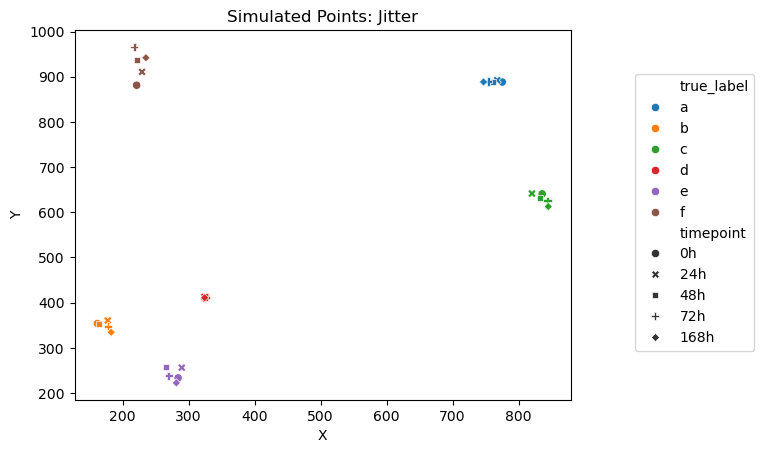

In [35]:
# Simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6
width = 1000
height = 1000

# create a random number generator instance for consistent seeding
rng = np.random.default_rng(seed = 2025)

# Define rotations, translations, and individual movements for each time point
#rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
#translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]

# Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
# individual movement given by a list of dictionaries with point labels as keys and 
# percentage movement by values
# the total number of dictionaries should match the total number of time steps to perturb
individual_movements = [
    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
] 

# Create a simulator instance
simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)

# Run the simulation
simulated_data = simulator.simulate(
    time_points=timepoints, 
    #rotations=rotations, 
    #translations=translations, 
    individual_movements=individual_movements,
    mvmnt_type='min'
)

df = simulated_data.copy()
df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])

# prep the data for matching algorithm
dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values 
dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values 

simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

# Plot all points in the "well"
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    data = simulated_data_long_true,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'true_label', 
    style = 'timepoint',
    ax=ax
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Simulated Points: Jitter')
leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
plt.show()
plt.close()

### LAP Tracking (Trackmate)

In [36]:
simulated_data_long_true = simulated_data_long_true.rename(
    columns={
        'raw_x': 'x', 
        'raw_y': 'y',
        'Timepoint': 'timepoint'
    }
)

In [37]:
# Step 1: Map timepoint strings to frame numbers
timepoint_order = ['0h', '24h', '48h', '72h', '168h']
timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
simulated_data_long_true['frame'] = simulated_data_long_true['timepoint'].map(timepoint_to_frame)

In [38]:
# Step 3: Apply LapTrack
tracker = LapTrack()
tracks_df, links_df, _ = tracker.predict_dataframe(
    simulated_data_long_true, 
    coordinate_cols=['x', 'y'],
    only_coordinate_cols=True
)

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/laptrack/_tracking.py:808: FutureWarning: The parameter only_coordinate_cols will be False by default in the major release.
  warnings.warn(


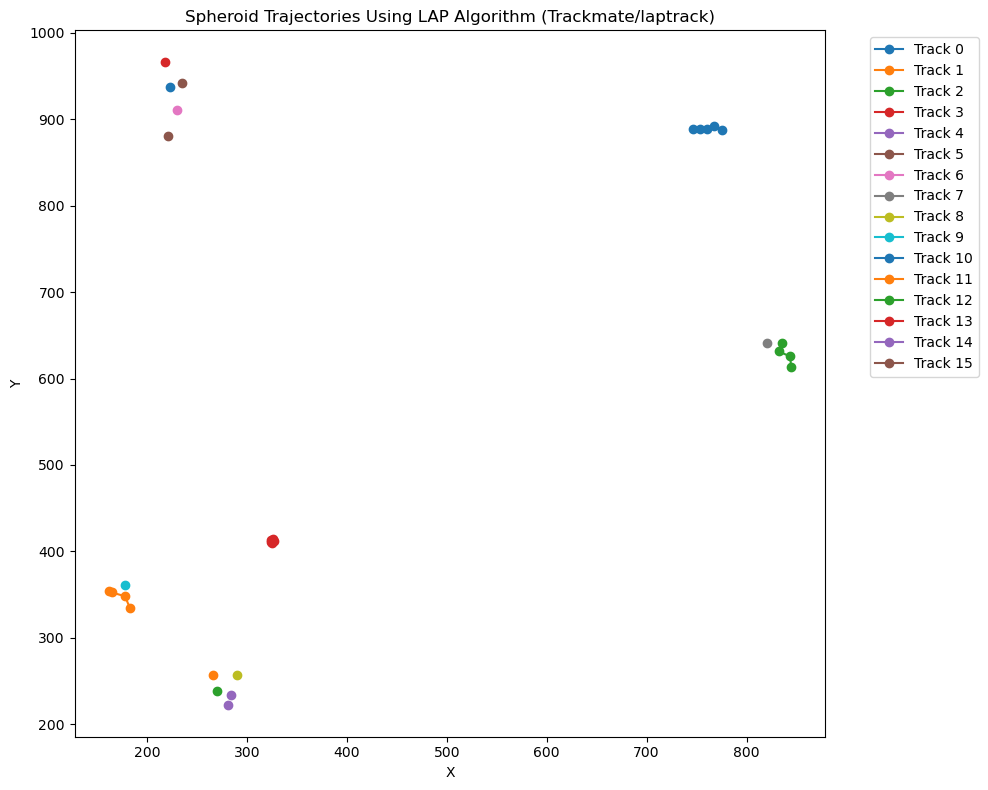

In [39]:
# Assumes `tracks_df` contains columns: 'x', 'y', 'frame', 'track_id'
plt.figure(figsize=(10, 8))

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    plt.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spheroid Trajectories Using LAP Algorithm (Trackmate/laptrack)')
#plt.gca().invert_yaxis()  # Optional: invert Y-axis to match microscope convention
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

In [41]:
# Merge predicted and ground truth data
df_long = simulated_data_long_true.copy()
#df_long['frame'] = df_long['Timepoint'].map(timepoint_to_frame)
#df_long = df_long.rename(columns={'raw_x': 'x', 'raw_y': 'y'})
df_merged = tracks_df.merge(df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y'])
track_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
df_merged['track_id_label'] = df_merged['track_id'].map(track_id_mapping, na_action='ignore')

# Compare `track_id` (predicted) to `true_label` (ground truth)
# Map labels to integers for ARI or clustering metrics
true_labels = df_merged['true_label']
pred_labels = df_merged['track_id_label']

# Accuracy (if labels are aligned one-to-one, 1.0 = 100%)
# taking the everything *after* the first time point to ensure proper tracking comparison
laptrack_accuracy = calc_accuracy(true_labels[6:], pred_labels[6:]) #accuracy_score(true_labels, pred_labels)*100

# Clustering-based similarity (more robust to label permutation)
#laptrack_ari = adjusted_rand_score(true_labels, pred_labels)

print(f"Tracking Accuracy: {laptrack_accuracy:.2f}")
#print(f"Adjusted Rand Index: {laptrack_ari:.2f}")

Tracking Accuracy: 58.33


### Crocker-Grier (pcnaDeep)

In [42]:
# The `search_range` parameter defines the maximum distance a particle can move between frames
linked_df = tp.link_df(simulated_data_long_true, search_range=250, memory=0)

# Now `linked_df` has an additional column 'particle' which is the track ID
print(linked_df.head(12))

Frame 4: 6 trajectories present.
   true_label timepoint           x           y  frame  particle
0           a        0h  775.200305  888.260152      0         0
1           b        0h  161.780023  353.965128      0         1
2           c        0h  835.644326  640.695652      0         2
3           d        0h  324.804797  409.646194      0         3
4           e        0h  284.175648  233.568921      0         4
5           f        0h  221.362889  881.169727      0         5
6           a       24h  767.578878  892.210302      1         0
7           f       24h  229.460544  910.720436      1         5
8           c       24h  820.151351  641.515431      1         2
9           d       24h  324.064455  412.659509      1         3
10          e       24h  289.744006  256.208305      1         4
11          b       24h  177.614991  360.599368      1         1


/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


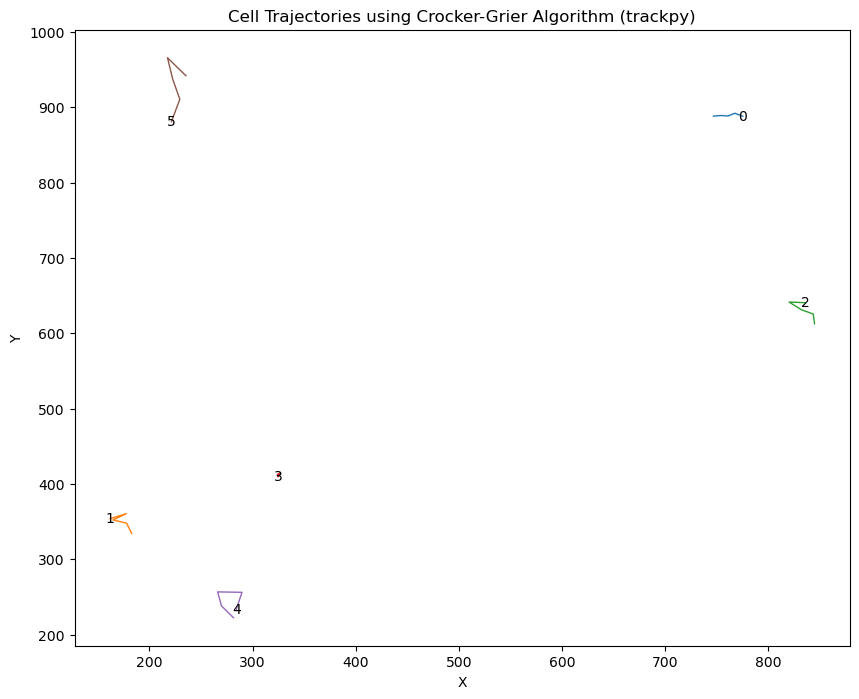

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(linked_df, label=True, ax=ax)
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Cell Trajectories using Crocker-Grier Algorithm (trackpy)')
plt.show()

In [45]:
# Step 1: Merge trackpy and ground truth data
merged_df = pd.merge(linked_df, df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y', 'true_label'])
merged_df['particle_str'] = [str(i) for i in merged_df['particle']]

# Step 2: Compute confusion matrix
#conf_mat = confusion_matrix(merged_df['true_label'], merged_df['particle_str'])

# Step 3: Hungarian algorithm for optimal label mapping
#row_ind, col_ind = linear_sum_assignment(-conf_mat)
#mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

# Step 4: Apply mapping
#merged_df['particle_aligned'] = merged_df['particle'].map(mapping)
particle_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
merged_df['particle_str'] = merged_df['particle'].map(particle_id_mapping)

# Step 5: Calculate accuracy (1.0 = 100%)
tp_accuracy = calc_accuracy(merged_df['true_label'][6:], merged_df['particle_str'][6:])#accuracy_score(merged_df['true_label'], merged_df['particle_str'])*100

# Clustering-based similarity (more robust to label permutation)
#tp_ari = adjusted_rand_score(merged_df['true_label'], merged_df['particle_str'])

print(f"Trackpy tracking accuracy: {tp_accuracy:.2f}")
#print(f"Trackpy tracking adjusted Rand Index: {tp_ari:.2f}")

Trackpy tracking accuracy: 100.00


### Procrustes Alignment (proposed algorithm/ASPHERE)

In [46]:
# prep the data for alignment
dataX = df[[col for col in df.columns if 'x' in col]].values #transpose
dataY = df[[col for col in df.columns if 'y' in col]].values #transpose

# Create an Aligner2D instance
aligner = Aligner2D(well_name="Simulated Data", time_points=timepoints)

# get the labels to use for the alignment
labels = list(df.label_0h)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

n_circles = len(np.unique(df.label_0h))
timepoints = ['0h', '24h', '48h', '72h', '168h']
simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

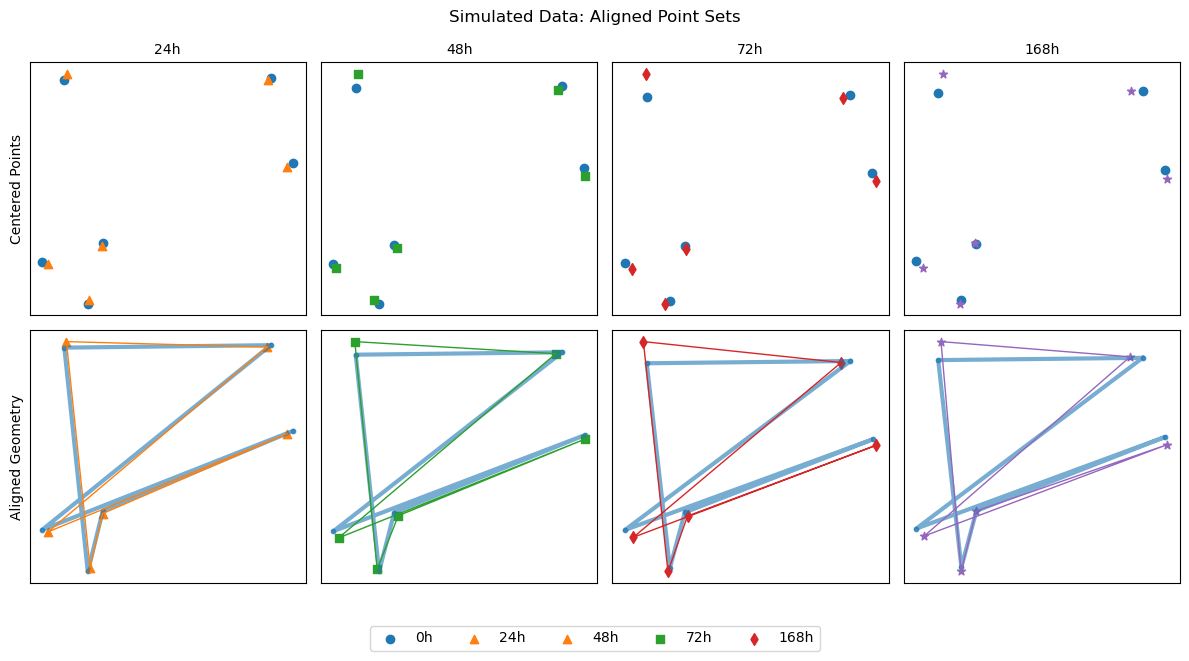

<Figure size 640x480 with 0 Axes>

In [47]:
# plotting
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, save=False, show_plot=True)#, save_dir='plots', )  # Pass fig and axs
#fig.savefig(os.path.join(out_dir, "rotation_translation_mpjitter_alignment.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [49]:
tracqc_acc = calc_accuracy(
    pd.Series(simulated_data_long_true['true_label'].values.astype(str))[6:], 
    pd.Series(aligner.registered_df['aligned_label'].values.astype(str))[6:]
)
print(f"Accuracy: {tracqc_acc}")

Accuracy: 100.0


### Overall Tracking Accuracy Figure (Jitter)

In [50]:
# Step 1: Create a DataFrame with results
accuracy_df = pd.DataFrame({
    'Tracker': ['LAP', 'Crocker-Grier', 'TRACE-QC'],
    'Accuracy': [laptrack_accuracy, tp_accuracy, tracqc_acc]
})

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_79281/2434247525.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


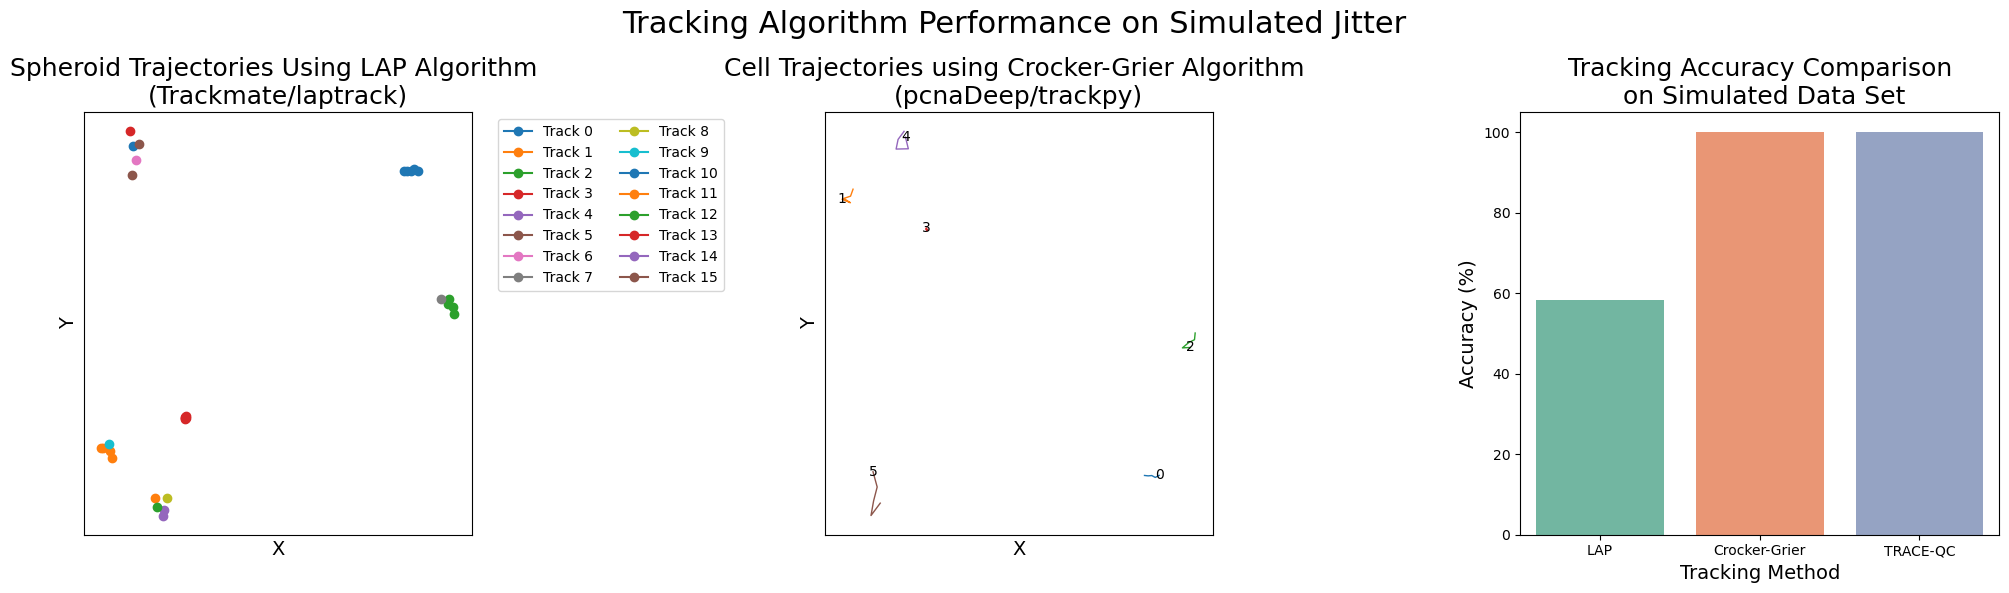

In [51]:
# figure parameters
title_fs = 22
annot_fs = 14
label_fs = 18
tick_fs = 14

fig, ax = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
ax = ax.ravel()

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    ax[0].plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

ax[0].set_xlabel('X', fontsize=tick_fs)
ax[0].set_ylabel('Y', fontsize=tick_fs)
ax[0].set_title('Spheroid Trajectories Using LAP Algorithm \n(Trackmate/laptrack)', fontsize=label_fs)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax[0].set_aspect('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])

tp.plot_traj(linked_df, label=True, ax=ax[1])
ax[1].set_xlabel('X', fontsize=tick_fs)
ax[1].set_ylabel('Y', fontsize=tick_fs)
ax[1].set_title('Cell Trajectories using Crocker-Grier Algorithm \n(pcnaDeep/trackpy)', fontsize=label_fs)
ax[1].set_aspect('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])

sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2', ax=ax[2])
ax[2].set_ylim(0, 105)
ax[2].set_title('Tracking Accuracy Comparison\n on Simulated Data Set', fontsize=label_fs)
ax[2].set_ylabel('Accuracy (%)', fontsize=tick_fs)
ax[2].set_xlabel('Tracking Method', fontsize=tick_fs)
#ax[2].set_aspect('equal')

fig.suptitle('Tracking Algorithm Performance on Simulated Jitter', y=0.98, fontsize=title_fs)

plt.tight_layout()
plt.show()
plt.close()

#### Store Results

In [52]:
# ['accuracy_df', 'sim_data', 'sim_data_long', 'tracks_df', 'linked_df', 'tp', 'aligner']
jitter_result = SimResult(accuracy_df, df, simulated_data_long_true, tracks_df, linked_df, tp, aligner)

## Simulated Data - Rotation Alone

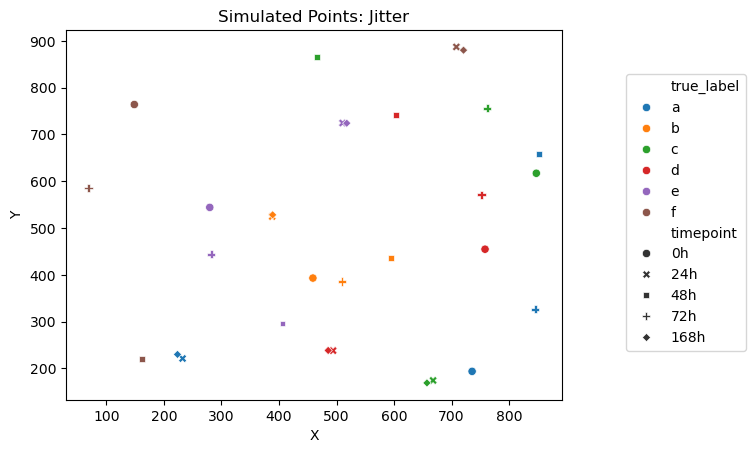

In [53]:
# Simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6
width = 1000
height = 1000

# create a random number generator instance for consistent seeding
rng = np.random.default_rng(seed = 42)

# Define rotations, translations, and individual movements for each time point
rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
#translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]

# Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
# individual movement given by a list of dictionaries with point labels as keys and 
# percentage movement by values
# the total number of dictionaries should match the total number of time steps to perturb
#individual_movements = [
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
#] 

# Create a simulator instance
simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)

# Run the simulation
simulated_data = simulator.simulate(
    time_points=timepoints, 
    rotations=rotations, 
    #translations=translations, 
    #individual_movements=individual_movements,
    mvmnt_type='min'
)

df = simulated_data.copy()
df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])

# prep the data for matching algorithm
dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values 
dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values 

simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

# Plot all points in the "well"
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    data = simulated_data_long_true,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'true_label', 
    style = 'timepoint',
    ax=ax
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Simulated Points: Jitter')
leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
plt.show()
plt.close()

### LAP Tracking (Trackmate)

In [54]:
simulated_data_long_true = simulated_data_long_true.rename(
    columns={
        'raw_x': 'x', 
        'raw_y': 'y',
        'Timepoint': 'timepoint'
    }
)

In [55]:
# Step 1: Map timepoint strings to frame numbers
timepoint_order = ['0h', '24h', '48h', '72h', '168h']
timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
simulated_data_long_true['frame'] = simulated_data_long_true['timepoint'].map(timepoint_to_frame)

In [56]:
# Step 3: Apply LapTrack
tracker = LapTrack()
tracks_df, links_df, _ = tracker.predict_dataframe(
    simulated_data_long_true, 
    coordinate_cols=['x', 'y'],
    only_coordinate_cols=True
)

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/laptrack/_tracking.py:808: FutureWarning: The parameter only_coordinate_cols will be False by default in the major release.
  warnings.warn(


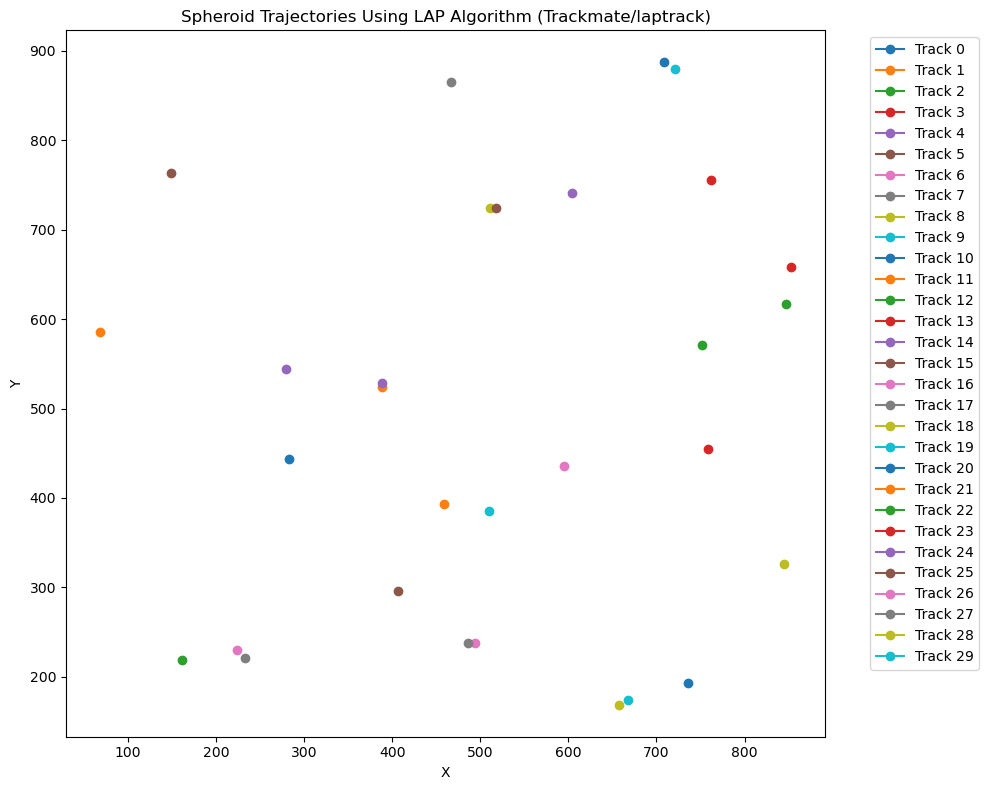

In [57]:
# Assumes `tracks_df` contains columns: 'x', 'y', 'frame', 'track_id'
plt.figure(figsize=(10, 8))

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    plt.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spheroid Trajectories Using LAP Algorithm (Trackmate/laptrack)')
#plt.gca().invert_yaxis()  # Optional: invert Y-axis to match microscope convention
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

In [59]:
# Merge predicted and ground truth data
df_long = simulated_data_long_true.copy()
#df_long['frame'] = df_long['Timepoint'].map(timepoint_to_frame)
#df_long = df_long.rename(columns={'raw_x': 'x', 'raw_y': 'y'})
df_merged = tracks_df.merge(df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y'])
track_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
df_merged['track_id_label'] = df_merged['track_id'].map(track_id_mapping, na_action='ignore')

# Compare `track_id` (predicted) to `true_label` (ground truth)
# Map labels to integers for ARI or clustering metrics
true_labels = df_merged['true_label']
pred_labels = df_merged['track_id_label']

# Accuracy (if labels are aligned one-to-one, 1.0 = 100%)
laptrack_accuracy = calc_accuracy(true_labels[6:], pred_labels[6:]) #accuracy_score(true_labels, pred_labels)*100

# Clustering-based similarity (more robust to label permutation)
#laptrack_ari = adjusted_rand_score(true_labels, pred_labels)

print(f"Tracking Accuracy: {laptrack_accuracy:.2f}")
#print(f"Adjusted Rand Index: {laptrack_ari:.2f}")

Tracking Accuracy: 0.00


### Crocker-Grier (pcnaDeep)

In [60]:
# The `search_range` parameter defines the maximum distance a particle can move between frames
linked_df = tp.link_df(simulated_data_long_true, search_range=250, memory=0)

# Now `linked_df` has an additional column 'particle' which is the track ID
print(linked_df.head(12))

Frame 4: 6 trajectories present.
   true_label timepoint           x           y  frame  particle
0           a        0h  735.716988  193.565633      0         0
1           b        0h  458.919557  393.020764      0         1
2           c        0h  847.386701  617.106208      0         2
3           d        0h  758.209291  454.731359      0         3
4           e        0h  279.608887  544.104508      0         4
5           f        0h  148.436708  764.070725      0         5
6           d       24h  493.962348  237.922083      1         1
7           a       24h  232.376794  220.997601      1         6
8           e       24h  510.557615  724.512777      1         7
9           c       24h  667.873636  174.101510      1         0
10          f       24h  708.367111  887.186315      1         8
11          b       24h  388.070240  524.574144      1         4


/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


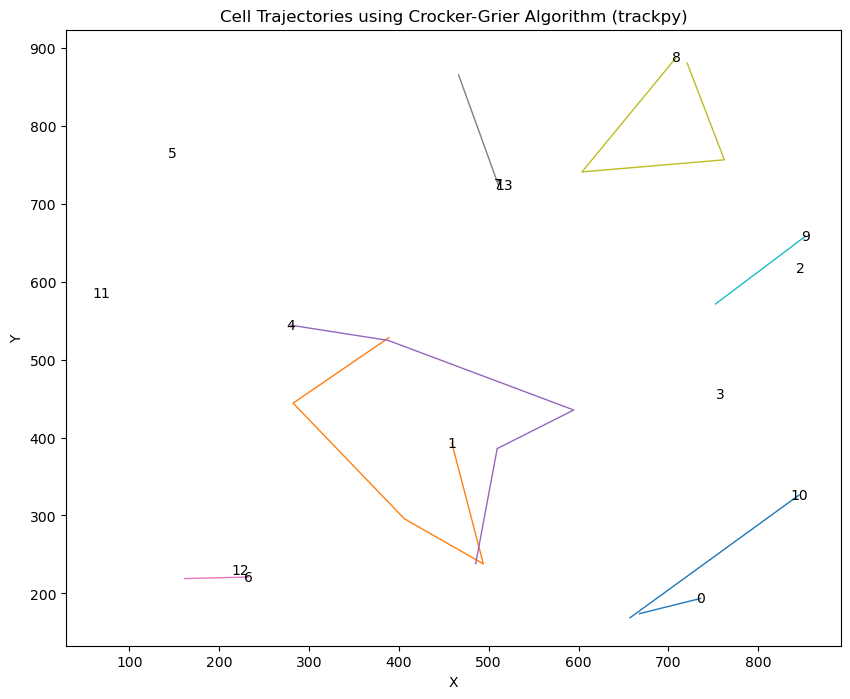

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(linked_df, label=True, ax=ax)
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Cell Trajectories using Crocker-Grier Algorithm (trackpy)')
plt.show()

In [63]:
# Step 1: Merge trackpy and ground truth data
merged_df = pd.merge(linked_df, df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y', 'true_label'])
merged_df['particle_str'] = [str(i) for i in merged_df['particle']]

# Step 2: Compute confusion matrix
#conf_mat = confusion_matrix(merged_df['true_label'], merged_df['particle_str'])

# Step 3: Hungarian algorithm for optimal label mapping
#row_ind, col_ind = linear_sum_assignment(-conf_mat)
#mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

# Step 4: Apply mapping
#merged_df['particle_aligned'] = merged_df['particle'].map(mapping)
particle_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
merged_df['particle_str'] = merged_df['particle'].map(particle_id_mapping)

# Step 5: Calculate accuracy (1.0 = 100%)
tp_accuracy = calc_accuracy(merged_df['true_label'][6:], merged_df['particle_str'][6:])#accuracy_score(merged_df['true_label'], merged_df['particle_str'])*100

# Clustering-based similarity (more robust to label permutation)
#tp_ari = adjusted_rand_score(merged_df['true_label'], merged_df['particle_str'])

print(f"Trackpy tracking accuracy: {tp_accuracy:.2f}")
#print(f"Trackpy tracking adjusted Rand Index: {tp_ari:.2f}")

Trackpy tracking accuracy: 4.17


### Procrustes Alignment (proposed algorithm/TracQC)

In [64]:
# prep the data for alignment
dataX = df[[col for col in df.columns if 'x' in col]].values #transpose
dataY = df[[col for col in df.columns if 'y' in col]].values #transpose

# Create an Aligner2D instance
aligner = Aligner2D(well_name="Simulated Data", time_points=timepoints)

# get the labels to use for the alignment
labels = list(df.label_0h)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

n_circles = len(np.unique(df.label_0h))
timepoints = ['0h', '24h', '48h', '72h', '168h']
simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

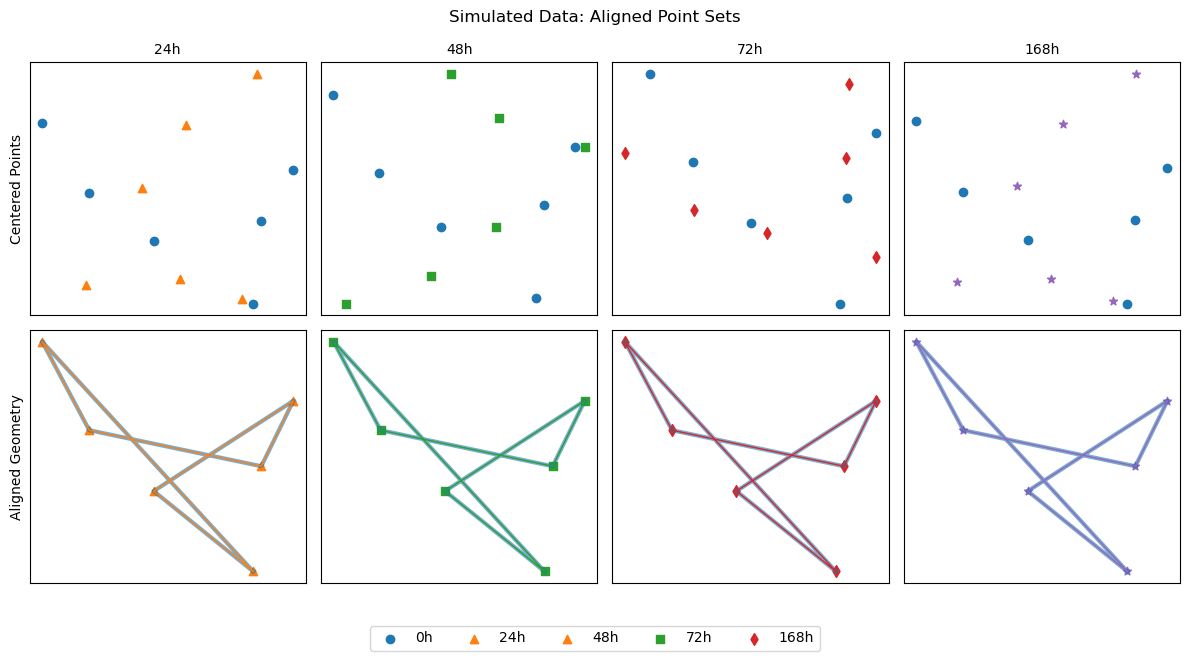

<Figure size 640x480 with 0 Axes>

In [65]:
# plotting
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, save=False, show_plot=True)#, save_dir='plots', )  # Pass fig and axs
#fig.savefig(os.path.join(out_dir, "rotation_translation_mpjitter_alignment.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [67]:
tracqc_acc = calc_accuracy(
    pd.Series(simulated_data_long_true['true_label'].values.astype(str)), 
    pd.Series(aligner.registered_df['aligned_label'].values.astype(str))
)
print(f"Accuracy: {tracqc_acc}")

Accuracy: 100.0


### Overall Tracking Accuracy Figure (Rotation)

In [68]:
# Step 1: Create a DataFrame with results
accuracy_df = pd.DataFrame({
    'Tracker': ['LAP', 'Crocker-Grier', 'TRACE-QC'],
    'Accuracy': [laptrack_accuracy, tp_accuracy, tracqc_acc]
})

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_79281/389382889.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


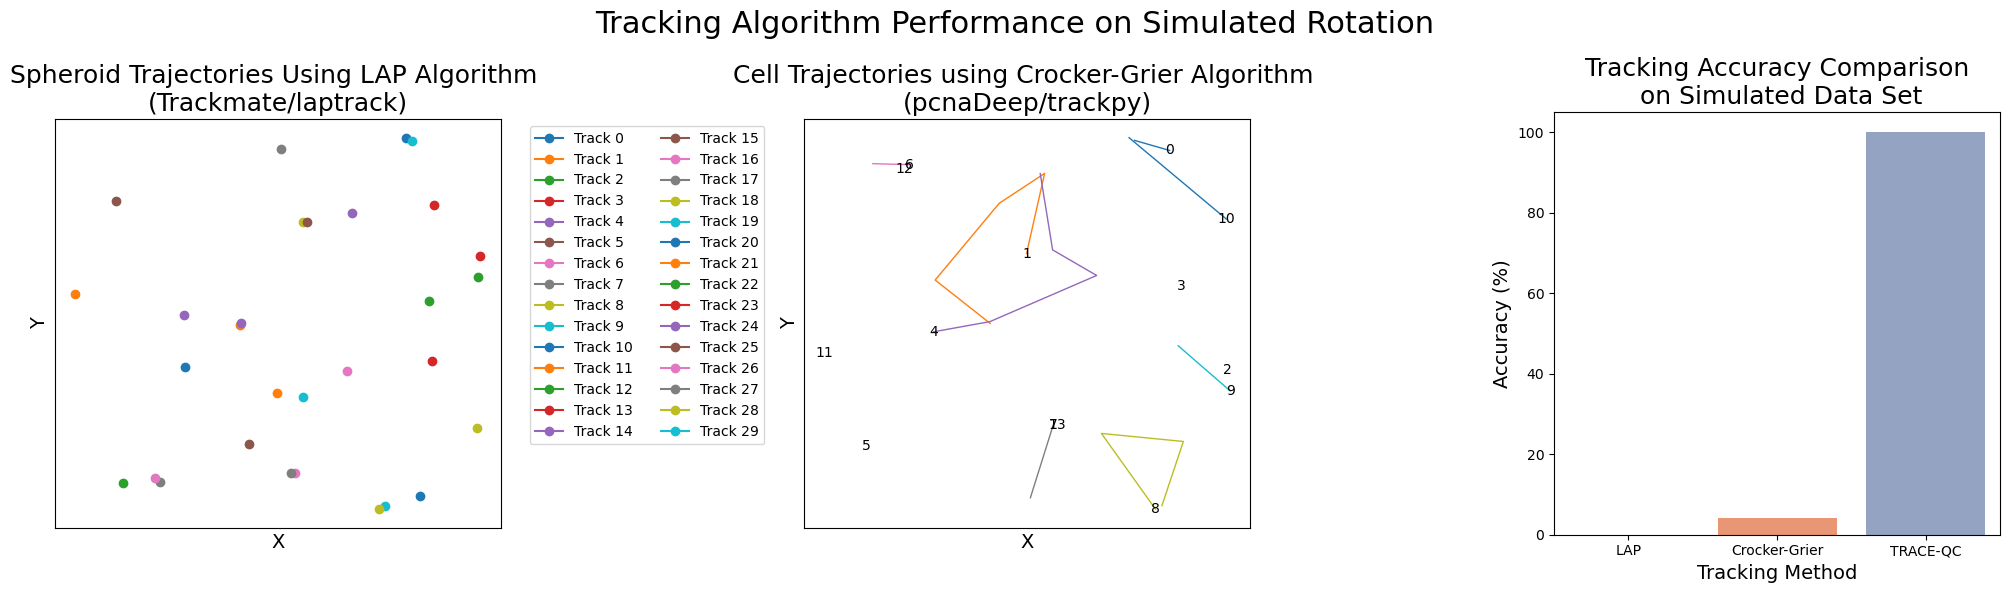

In [69]:
# figure parameters
title_fs = 22
annot_fs = 14
label_fs = 18
tick_fs = 14

fig, ax = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
ax = ax.ravel()

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    ax[0].plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

ax[0].set_xlabel('X', fontsize=tick_fs)
ax[0].set_ylabel('Y', fontsize=tick_fs)
ax[0].set_title('Spheroid Trajectories Using LAP Algorithm \n(Trackmate/laptrack)', fontsize=label_fs)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax[0].set_aspect('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])

tp.plot_traj(linked_df, label=True, ax=ax[1])
ax[1].set_xlabel('X', fontsize=tick_fs)
ax[1].set_ylabel('Y', fontsize=tick_fs)
ax[1].set_title('Cell Trajectories using Crocker-Grier Algorithm \n(pcnaDeep/trackpy)', fontsize=label_fs)
ax[1].set_aspect('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])

sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2', ax=ax[2])
ax[2].set_ylim(0, 105)
ax[2].set_title('Tracking Accuracy Comparison\n on Simulated Data Set', fontsize=label_fs)
ax[2].set_ylabel('Accuracy (%)', fontsize=tick_fs)
ax[2].set_xlabel('Tracking Method', fontsize=tick_fs)
#ax[2].set_aspect('equal')

fig.suptitle('Tracking Algorithm Performance on Simulated Rotation', y=0.98, fontsize=title_fs)

plt.tight_layout()
plt.show()
plt.close()

#### Store Result

In [70]:
# ['accuracy_df', 'sim_data', 'sim_data_long', 'tracks_df', 'linked_df', 'tp', 'aligner']
rotation_result = SimResult(accuracy_df, df, simulated_data_long_true, tracks_df, linked_df, tp, aligner)

## Simulated Data - Translation Alone

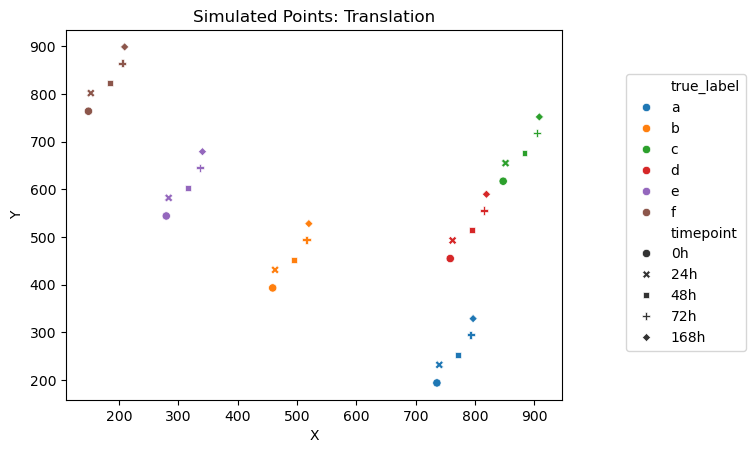

In [71]:
# Simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6
width = 1000
height = 1000

# create a random number generator instance for consistent seeding
rng = np.random.default_rng(seed = 42)

# Define rotations, translations, and individual movements for each time point
#rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]

# Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
# individual movement given by a list of dictionaries with point labels as keys and 
# percentage movement by values
# the total number of dictionaries should match the total number of time steps to perturb
#individual_movements = [
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
#    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
#] 

# Create a simulator instance
simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)

# Run the simulation
simulated_data = simulator.simulate(
    time_points=timepoints, 
    #rotations=rotations, 
    translations=translations, 
    #individual_movements=individual_movements,
    mvmnt_type='min'
)

df = simulated_data.copy()
df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])

# prep the data for matching algorithm
dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values 
dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values 

simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

# Plot all points in the "well"
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    data = simulated_data_long_true,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'true_label', 
    style = 'timepoint',
    ax=ax
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Simulated Points: Translation')
leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
plt.show()
plt.close()

### LAP Tracking (Trackmate)

In [72]:
simulated_data_long_true = simulated_data_long_true.rename(
    columns={
        'raw_x': 'x', 
        'raw_y': 'y',
        'Timepoint': 'timepoint'
    }
)

In [73]:
# Step 1: Map timepoint strings to frame numbers
timepoint_order = ['0h', '24h', '48h', '72h', '168h']
timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
simulated_data_long_true['frame'] = simulated_data_long_true['timepoint'].map(timepoint_to_frame)

In [74]:
# Step 3: Apply LapTrack
tracker = LapTrack()
tracks_df, links_df, _ = tracker.predict_dataframe(
    simulated_data_long_true, 
    coordinate_cols=['x', 'y'],
    only_coordinate_cols=True
)

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/laptrack/_tracking.py:808: FutureWarning: The parameter only_coordinate_cols will be False by default in the major release.
  warnings.warn(


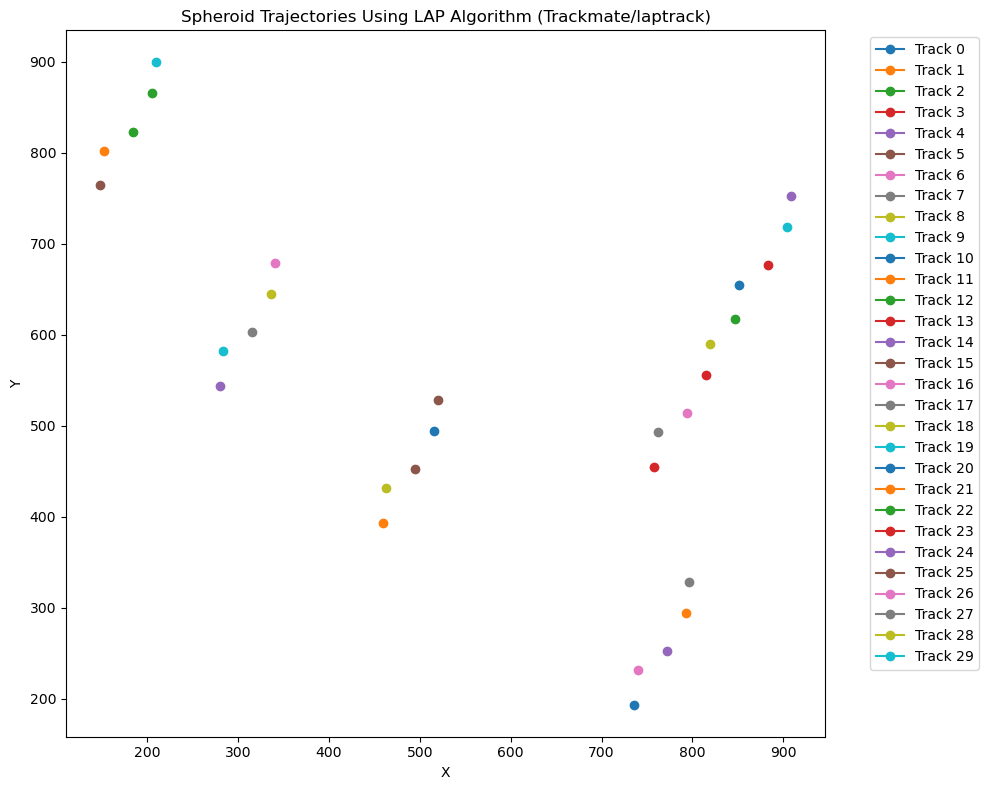

In [75]:
# Assumes `tracks_df` contains columns: 'x', 'y', 'frame', 'track_id'
plt.figure(figsize=(10, 8))

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    plt.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spheroid Trajectories Using LAP Algorithm (Trackmate/laptrack)')
#plt.gca().invert_yaxis()  # Optional: invert Y-axis to match microscope convention
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

In [77]:
# Merge predicted and ground truth data
df_long = simulated_data_long_true.copy()
#df_long['frame'] = df_long['Timepoint'].map(timepoint_to_frame)
#df_long = df_long.rename(columns={'raw_x': 'x', 'raw_y': 'y'})
df_merged = tracks_df.merge(df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y'])
track_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
df_merged['track_id_label'] = df_merged['track_id'].map(track_id_mapping, na_action='ignore')

# Compare `track_id` (predicted) to `true_label` (ground truth)
# Map labels to integers for ARI or clustering metrics
true_labels = df_merged['true_label']
pred_labels = df_merged['track_id_label']

# Accuracy (if labels are aligned one-to-one, 1.0 = 100%)
laptrack_accuracy = calc_accuracy(true_labels[6:], pred_labels[6:]) #accuracy_score(true_labels, pred_labels)*100

# Clustering-based similarity (more robust to label permutation)
#laptrack_ari = adjusted_rand_score(true_labels, pred_labels)

print(f"Tracking Accuracy: {laptrack_accuracy:.2f}")
#print(f"Adjusted Rand Index: {laptrack_ari:.2f}")

Tracking Accuracy: 0.00


### Crocker-Grier (pcnaDeep)

In [78]:
# The `search_range` parameter defines the maximum distance a particle can move between frames
linked_df = tp.link_df(simulated_data_long_true, search_range=250, memory=0)

# Now `linked_df` has an additional column 'particle' which is the track ID
print(linked_df.head(12))

Frame 4: 6 trajectories present.
   true_label timepoint           x           y  frame  particle
0           a        0h  735.716988  193.565633      0         0
1           b        0h  458.919557  393.020764      0         1
2           c        0h  847.386701  617.106208      0         2
3           d        0h  758.209291  454.731359      0         3
4           e        0h  279.608887  544.104508      0         4
5           f        0h  148.436708  764.070725      0         5
6           a       24h  739.716988  231.565633      1         0
7           d       24h  762.209291  492.731359      1         3
8           b       24h  462.919557  431.020764      1         1
9           e       24h  283.608887  582.104508      1         4
10          c       24h  851.386701  655.106208      1         2
11          f       24h  152.436708  802.070725      1         5


/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


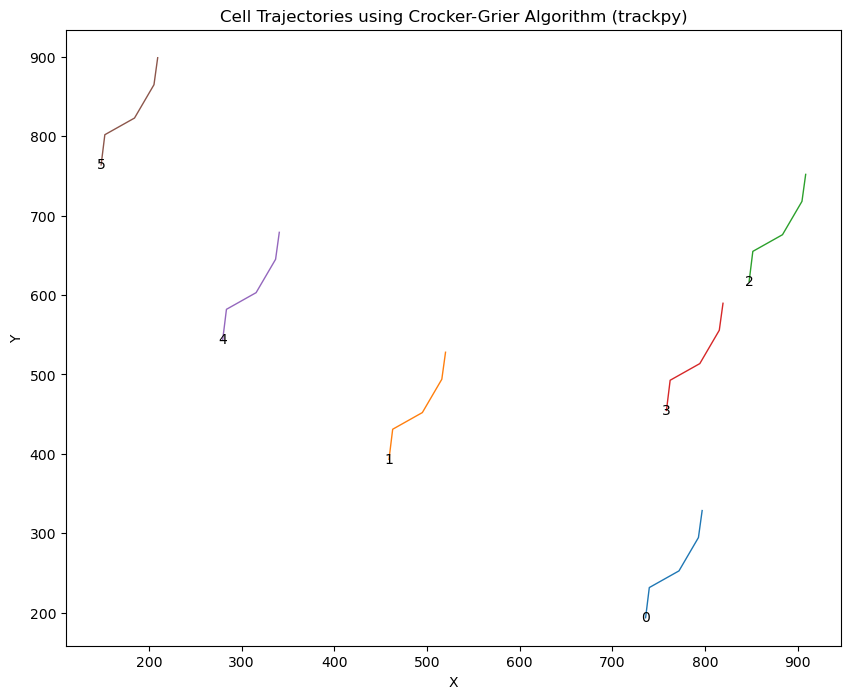

In [79]:
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(linked_df, label=True, ax=ax)
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Cell Trajectories using Crocker-Grier Algorithm (trackpy)')
plt.show()

In [81]:
# Step 1: Merge trackpy and ground truth data
merged_df = pd.merge(linked_df, df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y', 'true_label'])
merged_df['particle_str'] = [str(i) for i in merged_df['particle']]

# Step 2: Compute confusion matrix
#conf_mat = confusion_matrix(merged_df['true_label'], merged_df['particle_str'])

# Step 3: Hungarian algorithm for optimal label mapping
#row_ind, col_ind = linear_sum_assignment(-conf_mat)
#mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

# Step 4: Apply mapping
#merged_df['particle_aligned'] = merged_df['particle'].map(mapping)
particle_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
merged_df['particle_str'] = merged_df['particle'].map(particle_id_mapping)

# Step 5: Calculate accuracy (1.0 = 100%)
tp_accuracy = calc_accuracy(merged_df['true_label'][6:], merged_df['particle_str'][6:])#accuracy_score(merged_df['true_label'], merged_df['particle_str'])*100

# Clustering-based similarity (more robust to label permutation)
#tp_ari = adjusted_rand_score(merged_df['true_label'], merged_df['particle_str'])

print(f"Trackpy tracking accuracy: {tp_accuracy:.2f}")
#print(f"Trackpy tracking adjusted Rand Index: {tp_ari:.2f}")

Trackpy tracking accuracy: 100.00


### Procrustes Alignment (proposed algorithm/TRACE-QC)

In [82]:
# prep the data for alignment
dataX = df[[col for col in df.columns if 'x' in col]].values #transpose
dataY = df[[col for col in df.columns if 'y' in col]].values #transpose

# Create an Aligner2D instance
aligner = Aligner2D(well_name="Simulated Data", time_points=timepoints)

# get the labels to use for the alignment
labels = list(df.label_0h)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

n_circles = len(np.unique(df.label_0h))
timepoints = ['0h', '24h', '48h', '72h', '168h']
simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

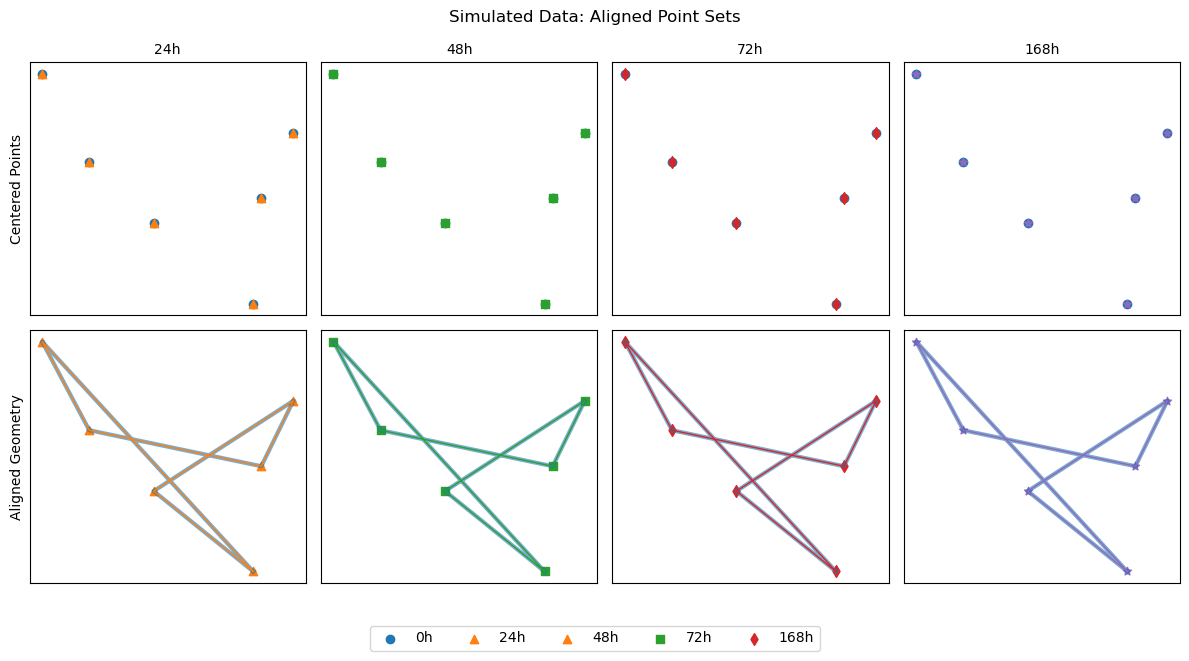

<Figure size 640x480 with 0 Axes>

In [83]:
# plotting
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, save=False, show_plot=True)#, save_dir='plots', )  # Pass fig and axs
#fig.savefig(os.path.join(out_dir, "rotation_translation_mpjitter_alignment.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

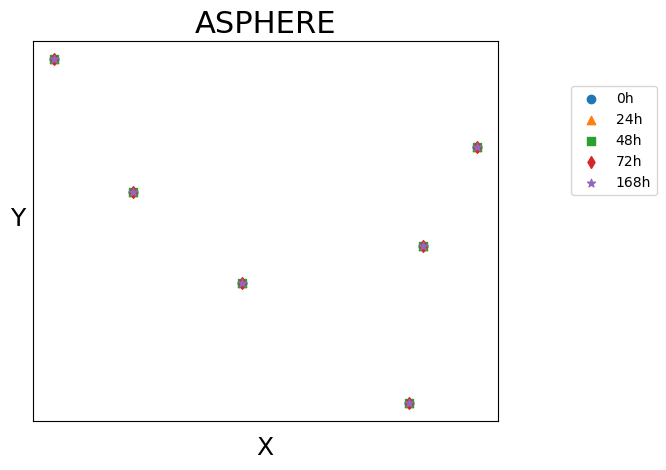

In [84]:
def plot_aligner_output(ax, aligner, **kwargs):
    opts = {
        'title_fs':14,
        'label_fs':12,
        'marker_shape':['o', '^', 's', 'd', '*'],
        'xlabel':'X',
        'ylabel':'Y',
        'title':'Post-Matching',
    }
    opts.update(kwargs)
    
    t0_pts = pd.DataFrame(aligner.centeredA, columns = ['registered_x', 'registered_y'])
    t0_pts['timepoint'] = '0h'
    
    aldf = pd.concat([
        t0_pts,
        aligner.registered_df[['registered_x', 'registered_y', 'timepoint']]
    ], axis=0)
    
    # after alignment
    for t, tp in enumerate(timepoints):
        tp_data = aldf[aldf['timepoint'] == tp]
        ax.scatter(
            tp_data['registered_x'],
            tp_data['registered_y'],
            marker=opts['marker_shape'][t],
            label=tp
        )
    
    ax.set_xlabel(opts['xlabel'], fontsize=label_fs)
    ax.set_ylabel(opts['ylabel'], fontsize=label_fs, rotation=0)
    ax.set_title(opts['title'], fontsize=title_fs)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(
        which='both',
        bottom=False,
        left=False
    )
    ax.set_aspect('equal')
    
    labels = timepoints
    leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))

    return ax

fig, ax = plt.subplots()
ax = plot_aligner_output(ax, aligner, title='ASPHERE') 
plt.tight_layout()
plt.show()
plt.close()

In [86]:
tracqc_acc = calc_accuracy(
    pd.Series(simulated_data_long_true['true_label'].values.astype(str))[6:], 
    pd.Series(aligner.registered_df['aligned_label'].values.astype(str))[6:]
)
print(f"Accuracy: {tracqc_acc}")

Accuracy: 100.0


### Overall Tracking Accuracy Figure (Rotation)

In [87]:
# Step 1: Create a DataFrame with results
accuracy_df = pd.DataFrame({
    'Tracker': ['LAP', 'Crocker-Grier', 'TRACE-QC'],
    'Accuracy': [laptrack_accuracy, tp_accuracy, tracqc_acc]
})

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_79281/953915471.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


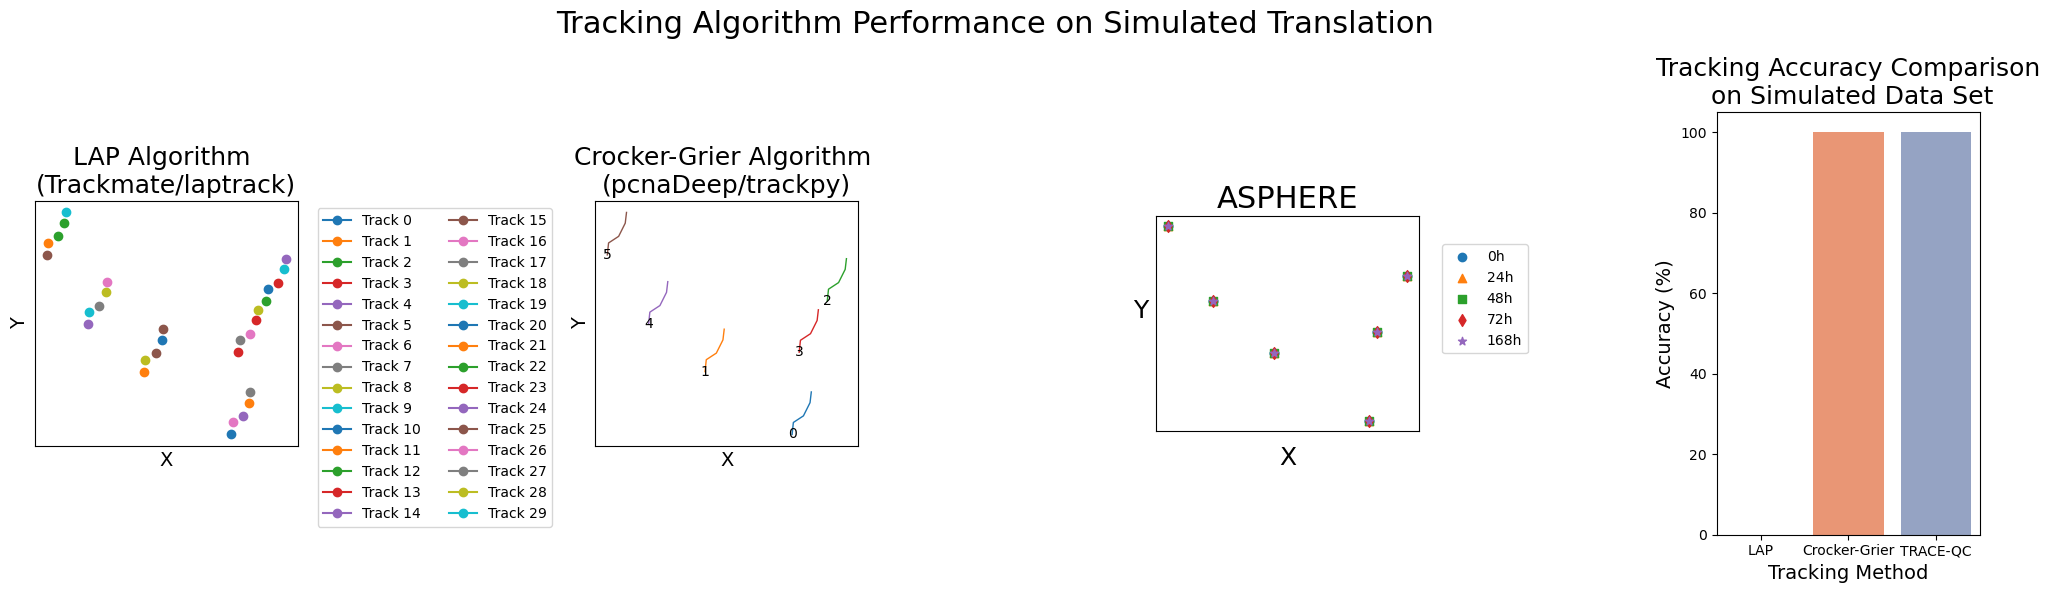

In [88]:
# figure parameters
title_fs = 22
annot_fs = 14
label_fs = 18
tick_fs = 14

fig, ax = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
ax = ax.ravel()

# Plot trajectories
for track_id, group in tracks_df.groupby('track_id'):
    ax[0].plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')

ax[0].set_xlabel('X', fontsize=tick_fs)
ax[0].set_ylabel('Y', fontsize=tick_fs)
ax[0].set_title('LAP Algorithm \n(Trackmate/laptrack)', fontsize=label_fs)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax[0].set_aspect('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])

tp.plot_traj(linked_df, label=True, ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_xlabel('X', fontsize=tick_fs)
ax[1].set_ylabel('Y', fontsize=tick_fs)
ax[1].set_title('Crocker-Grier Algorithm \n(pcnaDeep/trackpy)', fontsize=label_fs)
ax[1].set_aspect('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2] = plot_aligner_output(ax[2], aligner, title='ASPHERE') 
ax[2].set_aspect('equal')

sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2', ax=ax[3])
ax[3].set_ylim(0, 105)
ax[3].set_title('Tracking Accuracy Comparison\n on Simulated Data Set', fontsize=label_fs)
ax[3].set_ylabel('Accuracy (%)', fontsize=tick_fs)
ax[3].set_xlabel('Tracking Method', fontsize=tick_fs)
#ax[2].set_aspect('equal')

fig.suptitle('Tracking Algorithm Performance on Simulated Translation', y=0.98, fontsize=title_fs)

plt.tight_layout()
plt.show()
plt.close()

#### Store Result

In [89]:
# ['accuracy_df', 'sim_data', 'sim_data_long', 'tracks_df', 'linked_df', 'tp', 'aligner']
translation_result = SimResult(accuracy_df, df, simulated_data_long_true, tracks_df, linked_df, tp, aligner)

## Comparison Figures - Single Sim

In [90]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

def plot_simulation_data(data, ax, **kwargs):
    opts = {
        'tick_fs':12,
        'label_fs':14,
        'title_fs':18,
        'title':''
    }
    opts.update(kwargs)
    # Plot all points in the "well"
    sns.scatterplot(
        data = data,
        x = 'raw_x',
        y = 'raw_y',
        hue = 'true_label', 
        style = 'timepoint',
        ax=ax
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(opts['title'])
    leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(
        which='both',
        bottom=False,
        left=False
    )
    return ax

def plot_laptrack(tracks_df, ax_plot, ax_legend):
    # Plot trajectories
    for track_id, group in tracks_df.groupby('track_id'):
        ax_plot.plot(group['x'], group['y'], marker='o', label=f'Track {track_id}')
    ax_plot.set_xlabel('X')
    ax_plot.set_ylabel('Y')
    ax_plot.set_title('LAP (Trackmate/laptrack)\nPredicted Matches')
    #plt.gca().invert_yaxis()  # Optional: invert Y-axis to match microscope convention
    #ax_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    ax_plot.set_aspect('equal')

    #ax_legend.axis('off')
    legend = ax_plot.legend(loc='center', frameon=False, fontsize='small', ncol=1)
    #ax_legend.add_artist(legend)
    
    # Manually extract handles and labels from ax_lap
    handles, labels = ax_plot.get_legend_handles_labels()
    
    # Create new legend in ax_legend
    ax_legend.legend(handles, labels, loc='center', frameon=False, fontsize='small', ncol=2)
    ax_legend.axis('off')
    ax_plot.get_legend().remove()

    ax_plot.set_xticklabels([])
    ax_plot.set_yticklabels([])
    ax_plot.tick_params(
        which='both',
        bottom=False,
        left=False
    )
        
    return ax_plot, ax_legend

def plot_trackpy(tp, linked_df, ax, **kwargs):
    opts = {
        'tick_fs':12,
        'label_fs':14,
        'title_fs':18
    }
    opts.update(kwargs)
    tp.plot_traj(linked_df, label=True, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Crocker-Grier (pcnaDeep/trackpy)\nPredicted Matches')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    return ax

def plot_aligner_output(ax, aligner, **kwargs):
    opts = {
        'title_fs':14,
        'label_fs':12,
        'marker_shape':['o', '^', 's', 'd', '*'],
        'xlabel':'X',
        'ylabel':'Y',
        'title':'Post-Matching',
    }
    opts.update(kwargs)
    
    t0_pts = pd.DataFrame(aligner.centeredA, columns = ['registered_x', 'registered_y'])
    t0_pts['timepoint'] = '0h'
    
    aldf = pd.concat([
        t0_pts,
        aligner.registered_df[['registered_x', 'registered_y', 'timepoint']]
    ], axis=0)
    
    # after alignment
    for t, tp in enumerate(timepoints):
        tp_data = aldf[aldf['timepoint'] == tp]
        ax.scatter(
            tp_data['registered_x'],
            tp_data['registered_y'],
            marker=opts['marker_shape'][t],
            label=tp
        )
    
    ax.set_xlabel(opts['xlabel'])
    ax.set_ylabel(opts['ylabel'], rotation=0)
    ax.set_title(opts['title'])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(
        which='both',
        bottom=False,
        left=False
    )
    ax.set_aspect('equal')
    
    labels = timepoints
    leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))

    return ax

def plot_method_acc(accuracy_df, ax):
    sns.barplot(data=accuracy_df, x='Tracker', y='Accuracy', hue='Tracker', palette='Set2', ax=ax)
    ax.set_ylim(0, accuracy_df['Accuracy'].max()+5)
    ax.set_title('Tracking Accuracy')
    ax.set_ylabel('Accuracy (%)')
    #ax.set_xlabel('Tracking Method')
    #ax.set_aspect('equal')
    ax.autoscale()
    return ax

/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/cramere/miniforge3/envs/tracking-env/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfil

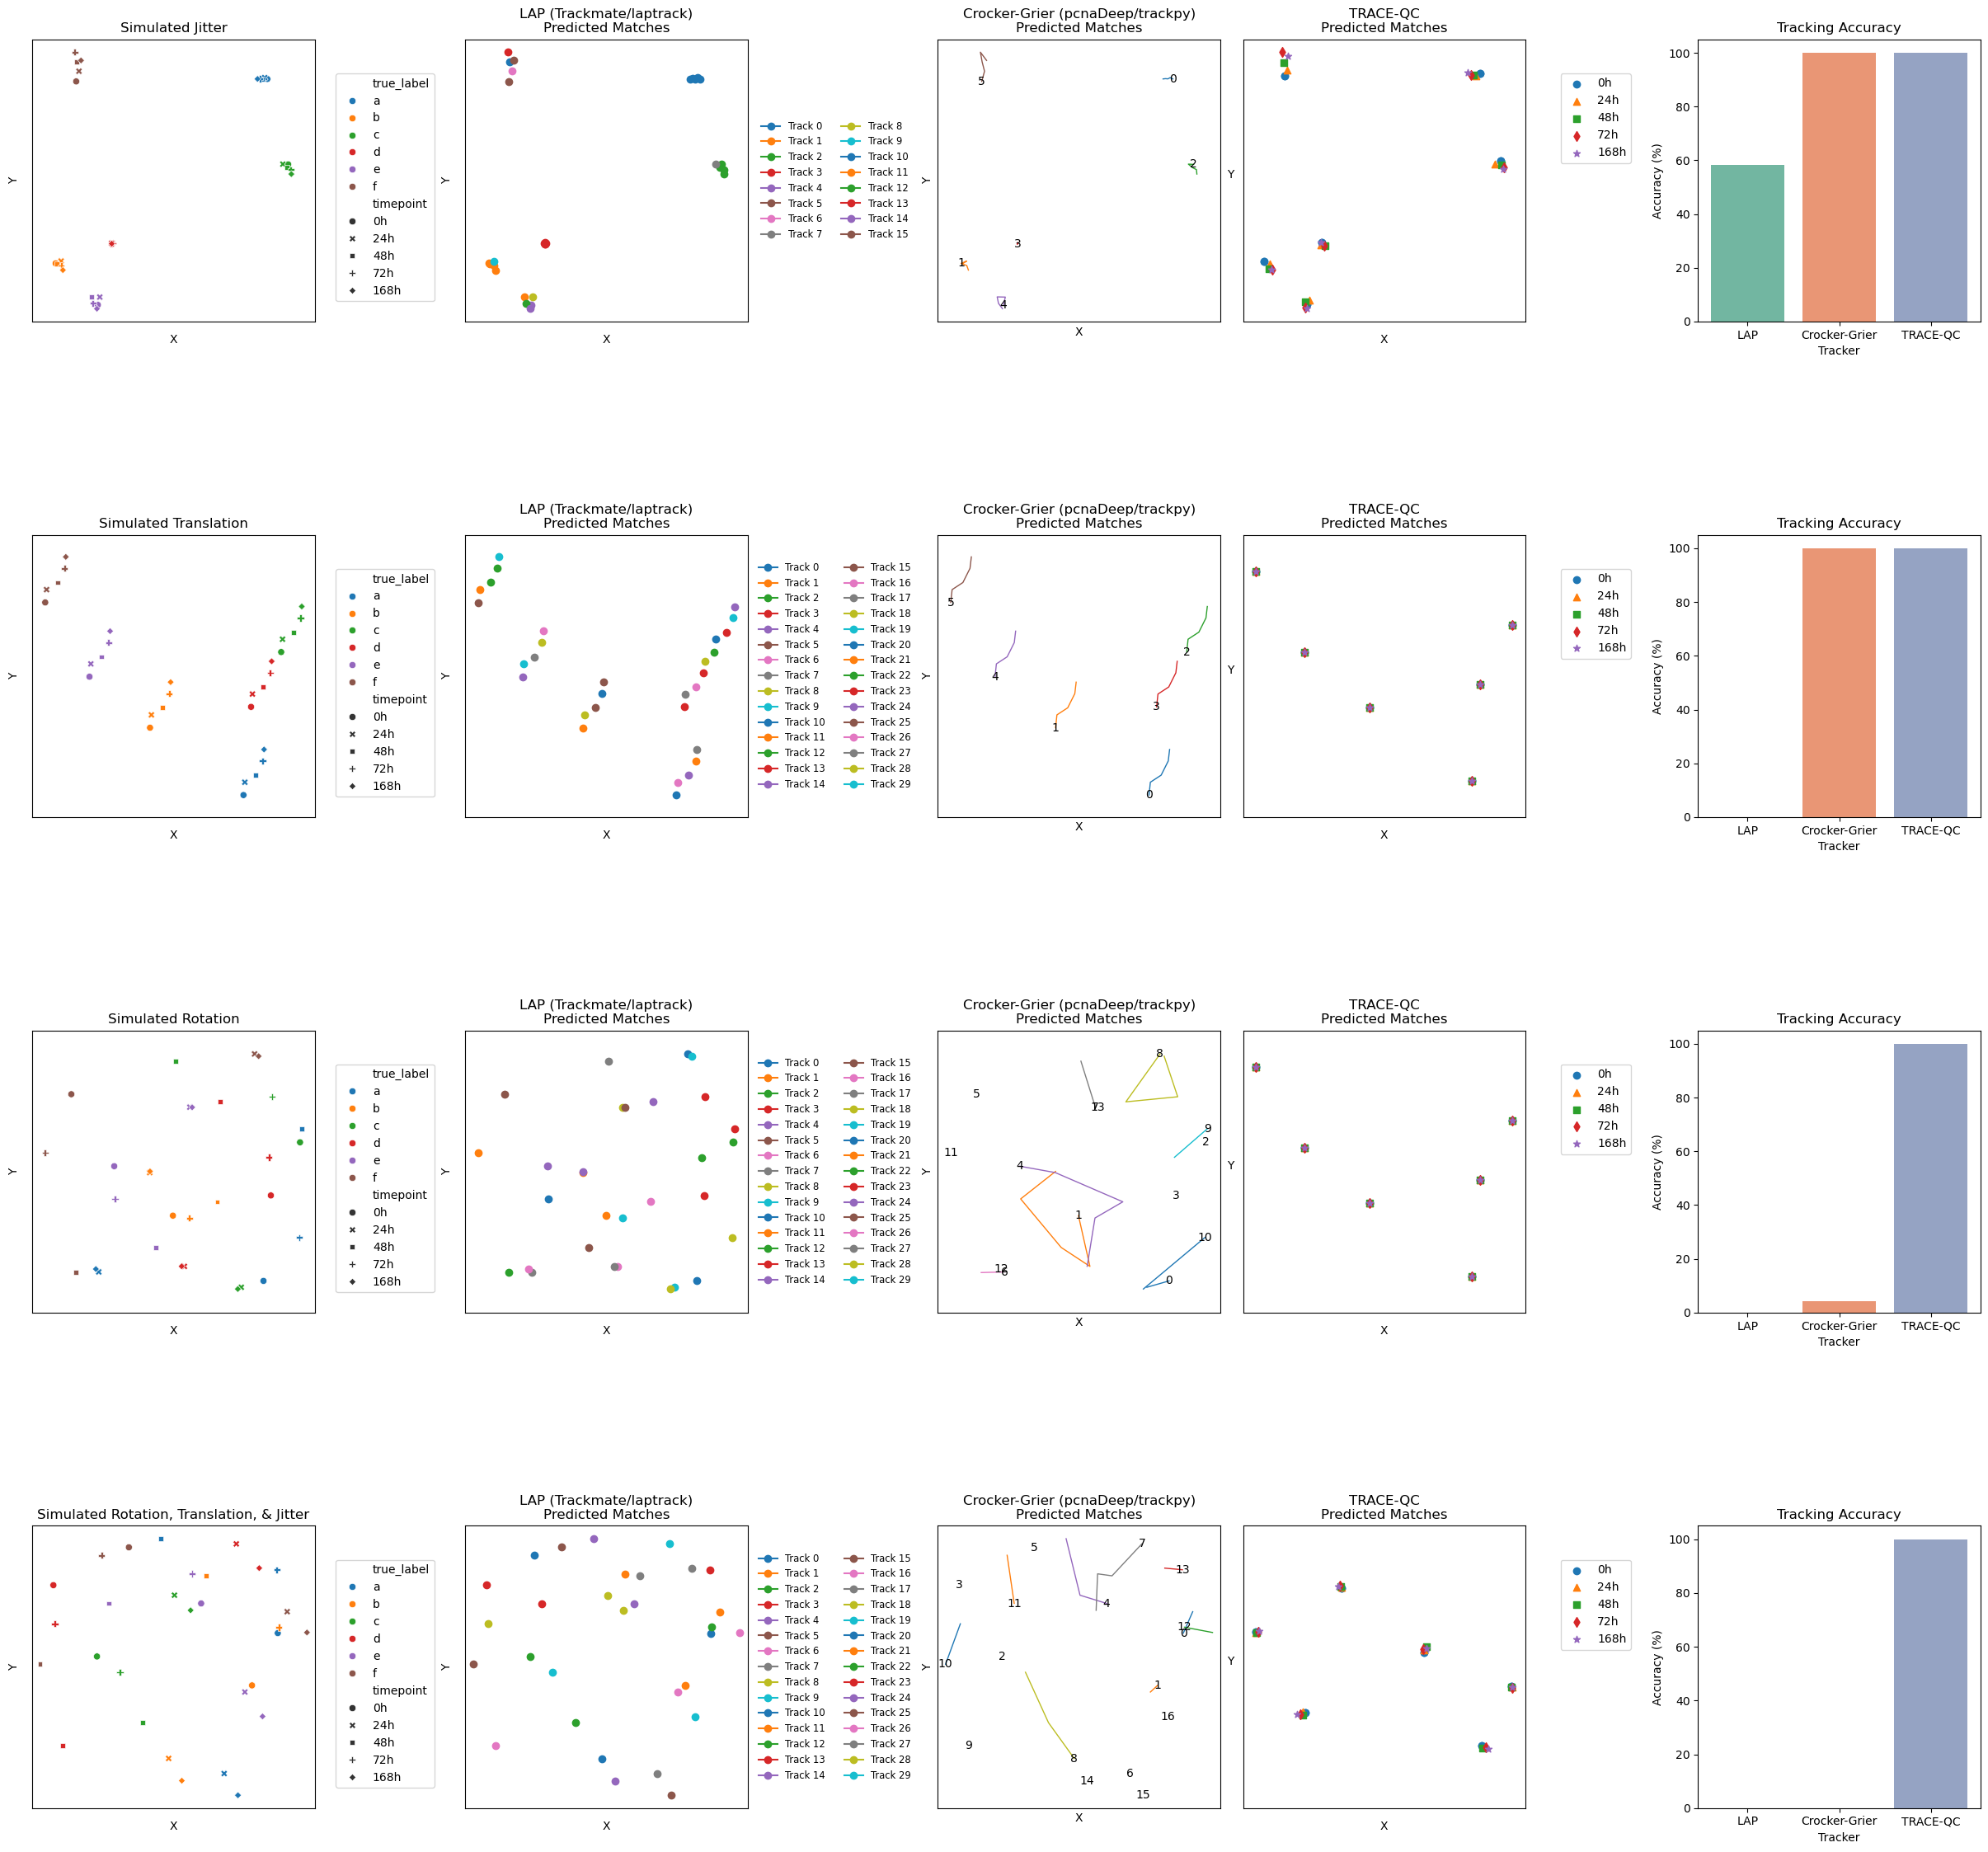

In [91]:
mosaic = "ABCDE.F;GHIJK.L;MNOPQ.R;STUVW.X"
fig = plt.figure(layout="constrained", figsize=(24, 24))
ax_dict = fig.subplot_mosaic(
    mosaic,
    width_ratios=[1, 1, 0.5, 1, 1, 0.05, 1],
    subplot_kw=dict(box_aspect=1)
)
#identify_axes(ax_dict)

# plotting the first row - jitter experiments
plot_simulation_data(jitter_result.sim_data_long, ax_dict['A'], title='Simulated Jitter')
#ax_dict['A'].annotate('Jitter', xy=(-20, 500), annotation_clip=False, rotation=90, fontsize=18)
plot_laptrack(jitter_result.tracks_df, ax_dict['B'], ax_dict['C'])
plot_trackpy(jitter_result.tp, jitter_result.linked_df, ax_dict['D'])
plot_aligner_output(ax_dict['E'], jitter_result.aligner, title='TRACE-QC\nPredicted Matches')
plot_method_acc(jitter_result.accuracy_df, ax_dict['F'])

# plotting second row - translation experiments
plot_simulation_data(translation_result.sim_data_long, ax_dict['G'], title='Simulated Translation')
#ax_dict['G'].annotate('Translation', xy=(-20, 425), annotation_clip=False, rotation=90, fontsize=18)
plot_laptrack(translation_result.tracks_df, ax_dict['H'], ax_dict['I'])
plot_trackpy(translation_result.tp, translation_result.linked_df, ax_dict['J'])
plot_aligner_output(ax_dict['K'], translation_result.aligner, title='TRACE-QC\nPredicted Matches')
plot_method_acc(translation_result.accuracy_df, ax_dict['L'])

# plotting third row - rotation experiments
plot_simulation_data(rotation_result.sim_data_long, ax_dict['M'], title='Simulated Rotation')
#ax_dict['M'].annotate('Rotation', xy=(-20, 450), annotation_clip=False, rotation=90, fontsize=18)
plot_laptrack(rotation_result.tracks_df, ax_dict['N'], ax_dict['O'])
plot_trackpy(rotation_result.tp, rotation_result.linked_df, ax_dict['P'])
plot_aligner_output(ax_dict['Q'], rotation_result.aligner, title='TRACE-QC\nPredicted Matches')
plot_method_acc(rotation_result.accuracy_df, ax_dict['R'])

# plotting fourth row - combined experiments
plot_simulation_data(combo_result.sim_data_long, ax_dict['S'], title='Simulated Rotation, Translation, & Jitter')
#ax_dict['S'].annotate('Combination', xy=(-20, 400), annotation_clip=False, rotation=90, fontsize=18)
plot_laptrack(combo_result.tracks_df, ax_dict['T'], ax_dict['U'])
plot_trackpy(combo_result.tp, combo_result.linked_df, ax_dict['V'])
plot_aligner_output(ax_dict['W'], combo_result.aligner, title='TRACE-QC\nPredicted Matches')
plot_method_acc(combo_result.accuracy_df, ax_dict['X'])

# view figure
fig.savefig('tracking_method_comparison_supplemental.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

## Multi-Simulation Accuracy Evaluation

In [129]:
# helper functions 

# calculate LAP accuracy
def calc_lap_acc(df):
    df_long = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)
    df_long = df_long.rename(
        columns={
            'raw_x': 'x', 
            'raw_y': 'y',
            'Timepoint': 'timepoint'
        }
    )
    # Step 1: Map timepoint strings to frame numbers
    timepoint_order = ['0h', '24h', '48h', '72h', '168h']
    timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
    df_long['frame'] = df_long['timepoint'].map(timepoint_to_frame)

    # Step 3: Apply LapTrack
    tracker = LapTrack()
    tracks_df, links_df, _ = tracker.predict_dataframe(
        df_long, 
        coordinate_cols=['x', 'y'],
        only_coordinate_cols=True
    )

    # Merge predicted and ground truth data
    df_merged = tracks_df.merge(df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y'])
    track_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    df_merged['track_id_label'] = df_merged['track_id'].map(track_id_mapping, na_action='ignore')
    
    # Compare `track_id` (predicted) to `true_label` (ground truth)
    # Map labels to integers for ARI or clustering metrics
    true_labels = df_merged['true_label']
    pred_labels = df_merged['track_id_label']
    
    # Accuracy (if labels are aligned one-to-one, 1.0 = 100%)
    # taking the everything *after* the first time point to ensure proper tracking comparison
    laptrack_accuracy = calc_accuracy(true_labels[6:], pred_labels[6:]) #accuracy_score(true_labels, pred_labels)*100

    return laptrack_accuracy
    
# calculate GC accuracy

def calc_cg_acc(df):
    df_long = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)
    df_long = df_long.rename(
        columns={
            'raw_x': 'x', 
            'raw_y': 'y',
            'Timepoint': 'timepoint'
        }
    )
    # Step 1: Map timepoint strings to frame numbers
    timepoint_order = ['0h', '24h', '48h', '72h', '168h']
    timepoint_to_frame = {tp: i for i, tp in enumerate(timepoint_order)}
    df_long['frame'] = df_long['timepoint'].map(timepoint_to_frame)
    
    # The `search_range` parameter defines the maximum distance a particle can move between frames
    with contextlib.redirect_stdout(io.StringIO()):
        linked_df = tp.link_df(df_long, search_range=250, memory=0)
    merged_df = pd.merge(linked_df, df_long[['frame', 'x', 'y', 'true_label']], on=['frame', 'x', 'y', 'true_label'])
    merged_df['particle_str'] = [str(i) for i in merged_df['particle']]
    
    # Apply mapping
    particle_id_mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    merged_df['particle_str'] = merged_df['particle'].map(particle_id_mapping)
    
    # Calculate accuracy (1.0 = 100%)
    tp_accuracy = calc_accuracy(merged_df['true_label'][6:], merged_df['particle_str'][6:])

    return tp_accuracy
    
# calculate TQC accuracy
def calc_tqc_acc(df):
    dataX = df[[col for col in df.columns if 'x' in col]].values #transpose
    dataY = df[[col for col in df.columns if 'y' in col]].values #transpose
    
    n_circles = len(np.unique(df['label_0h']))
    timepoints = ['0h', '24h', '48h', '72h', '168h']
    
    # Create an Aligner2D instance
    aligner = Aligner2D(well_name="Simulated Data", time_points=timepoints)
    
    # get the labels to use for the alignment
    labels = list(df.label_0h)
    
    # Align the data (well_id 0 is just an example)
    aligner = aligner.align(dataX, dataY, labels_0=labels)
    
    simulated_data_long_true = build_long_true(df.drop('label_assumed', axis=1), n_circles, timepoints)

    tracqc_acc = calc_accuracy(
        pd.Series(simulated_data_long_true['true_label'].values.astype(str))[6:], 
        pd.Series(aligner.registered_df['aligned_label'].values.astype(str))[6:]
    )

    return tracqc_acc

In [150]:
# number of simulations to run
N=1000

### Jitter

In [133]:
# write a function to:
# run N simulations
# calculate LAP, GC, and TQC for each simulation
# save the accuracy for each simulation in a data frame

def simulate_jitter(N=1000):
    accuracies = {
        'LAP':[],
        'Crocker-Grier':[],
        'TRACE-QC':[]
    }
    # Simulation parameters
    timepoints = ["0h", "24h", "48h", "72h", "168h"]
    n_circles = 6
    width = 1000
    height = 1000
    
    # create a random number generator instance for consistent seeding
    #rng = np.random.default_rng(seed = 2025)

    for i in tqdm(range(N)):
        # Define rotations, translations, and individual movements for each time point
        #rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
        #translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]
        
        # Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
        # individual movement given by a list of dictionaries with point labels as keys and 
        # percentage movement by values
        # the total number of dictionaries should match the total number of time steps to perturb
        individual_movements = [
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
        ] 
        
        # Create a simulator instance
        simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)
        
        # Run the simulation
        df = simulator.simulate(
            time_points=timepoints, 
            #rotations=rotations, 
            #translations=translations, 
            individual_movements=individual_movements,
            mvmnt_type='min'
        )
        df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
        df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])
        accuracies['LAP'].append(calc_lap_acc(df)[0])
        accuracies['Crocker-Grier'].append(calc_cg_acc(df)[0])
        accuracies['TRACE-QC'].append(calc_tqc_acc(df)[0])
    accuracy_df = pd.DataFrame(accuracies)
    return accuracy_df

In [134]:
jitter_accuracies = simulate_jitter(N)

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.86it/s]


<Axes: xlabel='variable', ylabel='value'>

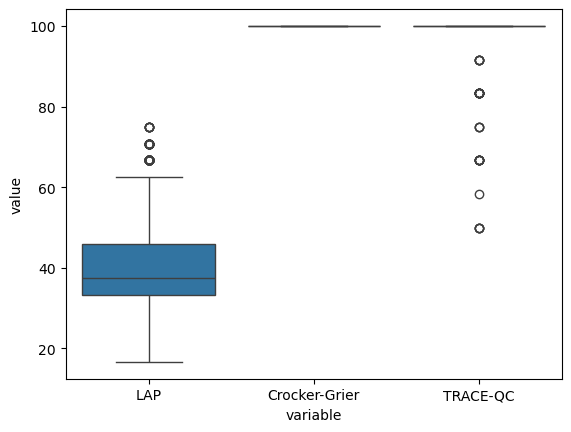

In [139]:
sns.boxplot(x='variable', y='value', data=jitter_accuracies.melt())

### Translation

In [142]:
def simulate_translation(N=1000):
    accuracies = {
        'LAP':[],
        'Crocker-Grier':[],
        'TRACE-QC':[]
    }
    # Simulation parameters
    timepoints = ["0h", "24h", "48h", "72h", "168h"]
    n_circles = 6
    width = 1000
    height = 1000
    
    # create a random number generator instance for consistent seeding
    #rng = np.random.default_rng(seed = 2025)

    for i in tqdm(range(N)):
        # Define rotations, translations, and individual movements for each time point
        #rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
        translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]
        
        # Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
        # individual movement given by a list of dictionaries with point labels as keys and 
        # percentage movement by values
        # the total number of dictionaries should match the total number of time steps to perturb
        #individual_movements = [
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
        #] 
        
        # Create a simulator instance
        simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)
        
        # Run the simulation
        df = simulator.simulate(
            time_points=timepoints, 
            #rotations=rotations, 
            translations=translations, 
            #individual_movements=individual_movements,
            mvmnt_type='min'
        )
        df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
        df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])
        accuracies['LAP'].append(calc_lap_acc(df)[0])
        accuracies['Crocker-Grier'].append(calc_cg_acc(df)[0])
        accuracies['TRACE-QC'].append(calc_tqc_acc(df)[0])
    accuracy_df = pd.DataFrame(accuracies)
    return accuracy_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.14it/s]


<Axes: xlabel='variable', ylabel='value'>

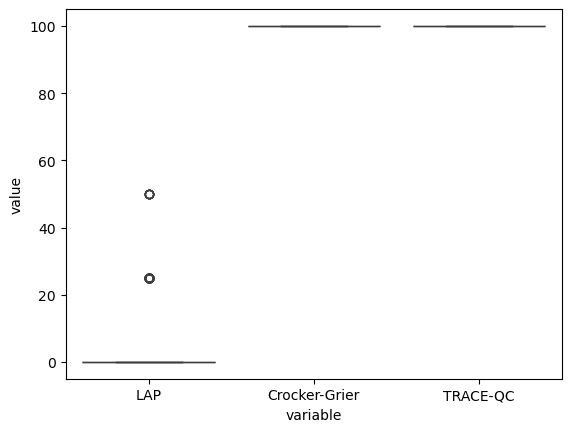

In [143]:
translation_accuracies = simulate_translation(N)
sns.boxplot(x='variable', y='value', data=translation_accuracies.melt())

### Rotation

In [145]:
def simulate_rotations(N=1000):
    accuracies = {
        'LAP':[],
        'Crocker-Grier':[],
        'TRACE-QC':[]
    }
    # Simulation parameters
    timepoints = ["0h", "24h", "48h", "72h", "168h"]
    n_circles = 6
    width = 1000
    height = 1000
    
    # create a random number generator instance for consistent seeding
    #rng = np.random.default_rng(seed = 2025)

    for i in tqdm(range(N)):
        # Define rotations, translations, and individual movements for each time point
        rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
        #translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]
        
        # Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
        # individual movement given by a list of dictionaries with point labels as keys and 
        # percentage movement by values
        # the total number of dictionaries should match the total number of time steps to perturb
        #individual_movements = [
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
        #    {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
        #] 
        
        # Create a simulator instance
        simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)
        
        # Run the simulation
        df = simulator.simulate(
            time_points=timepoints, 
            rotations=rotations, 
            #translations=translations, 
            #individual_movements=individual_movements,
            mvmnt_type='min'
        )
        df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
        df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])
        accuracies['LAP'].append(calc_lap_acc(df)[0])
        accuracies['Crocker-Grier'].append(calc_cg_acc(df)[0])
        accuracies['TRACE-QC'].append(calc_tqc_acc(df)[0])
    accuracy_df = pd.DataFrame(accuracies)
    return accuracy_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.84it/s]


<Axes: xlabel='variable', ylabel='value'>

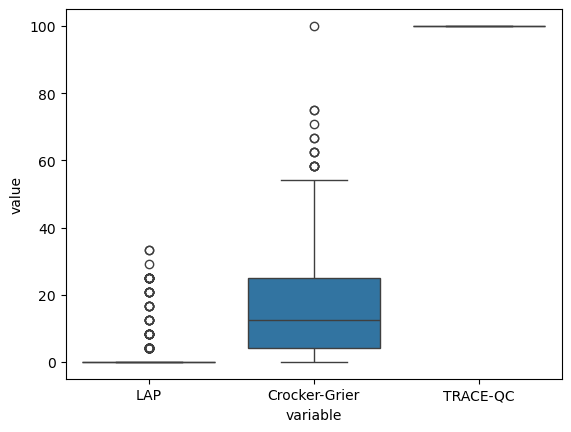

In [146]:
rotation_accuracies = simulate_rotations(N)
sns.boxplot(x='variable', y='value', data=rotation_accuracies.melt())

### Combination

In [147]:
def simulate_combos(N=1000):
    accuracies = {
        'LAP':[],
        'Crocker-Grier':[],
        'TRACE-QC':[]
    }
    # Simulation parameters
    timepoints = ["0h", "24h", "48h", "72h", "168h"]
    n_circles = 6
    width = 1000
    height = 1000
    
    # create a random number generator instance for consistent seeding
    #rng = np.random.default_rng(seed = 2025)

    for i in tqdm(range(N)):
        # Define rotations, translations, and individual movements for each time point
        rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
        translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]
        
        # Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
        # individual movement given by a list of dictionaries with point labels as keys and 
        # percentage movement by values
        # the total number of dictionaries should match the total number of time steps to perturb
        individual_movements = [
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},  
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20}, 
            {'a': 0.05, 'b':0.1, 'c': 0.1, 'd': 0.02, 'e': 0.15, 'f':0.20},
        ] 
        
        # Create a simulator instance
        simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)
        
        # Run the simulation
        df = simulator.simulate(
            time_points=timepoints, 
            rotations=rotations, 
            translations=translations, 
            individual_movements=individual_movements,
            mvmnt_type='min'
        )
        df.rename(columns={df.columns[0]: "label_0h" }, inplace = True)
        df.insert(loc=0, column='label_assumed', value=['a', 'b', 'c', 'd', 'e', 'f'])
        accuracies['LAP'].append(calc_lap_acc(df)[0])
        accuracies['Crocker-Grier'].append(calc_cg_acc(df)[0])
        accuracies['TRACE-QC'].append(calc_tqc_acc(df)[0])
    accuracy_df = pd.DataFrame(accuracies)
    return accuracy_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.65it/s]


<Axes: xlabel='variable', ylabel='value'>

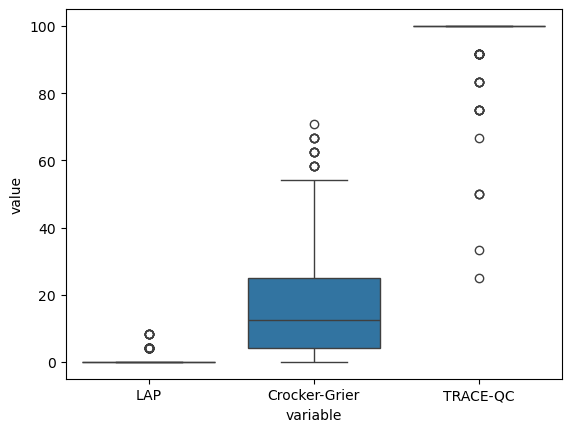

In [148]:
combo_accuracies = simulate_combos(N)
sns.boxplot(x='variable', y='value', data=combo_accuracies.melt())

## Comparison Figure - Multi Sim

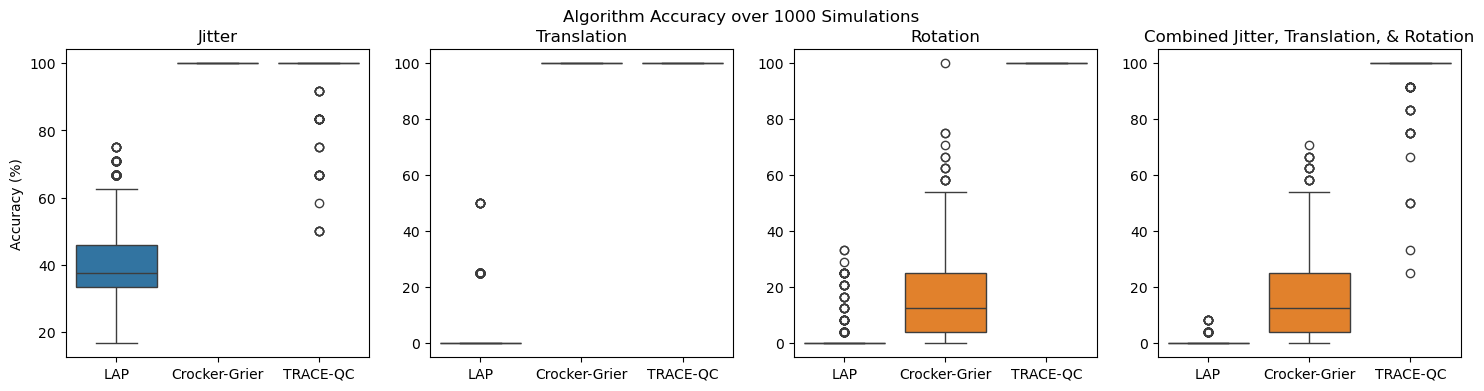

In [157]:
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
ax=ax.ravel()

sns.boxplot(x='variable', y='value', hue='variable', data=jitter_accuracies.melt(), ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Jitter')

sns.boxplot(x='variable', y='value', hue='variable', data=translation_accuracies.melt(), ax=ax[1])
ax[1].set_xlabel('')
#ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylabel('')
ax[1].set_title('Translation')

sns.boxplot(x='variable', y='value', hue='variable', data=rotation_accuracies.melt(), ax=ax[2])
ax[2].set_xlabel('')
#ax[2].set_ylabel('Accuracy (%)')
ax[2].set_ylabel('')
ax[2].set_title('Rotation')

sns.boxplot(x='variable', y='value', hue='variable', data=combo_accuracies.melt(), ax=ax[3])
ax[3].set_xlabel('')
#ax[3].set_ylabel('Accuracy (%)')
ax[3].set_ylabel('')
ax[3].set_title('Combined Jitter, Translation, & Rotation')

fig.suptitle(f'Algorithm Accuracy over {N} Simulations', y=0.98)
fig.savefig(f'algorithm_accuracy_comparison_N={N}_simulations.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

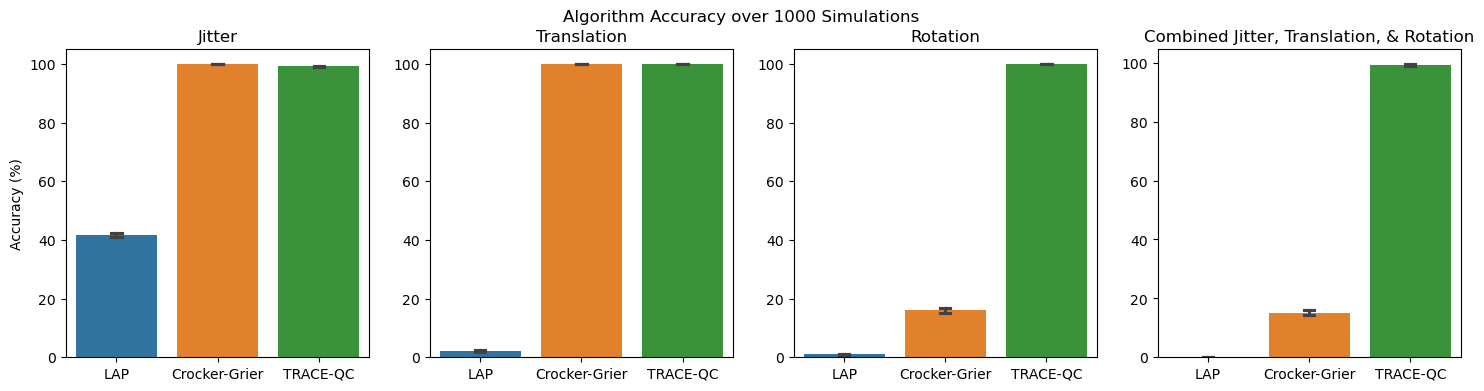

In [160]:
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
ax=ax.ravel()

sns.barplot(x='variable', y='value', hue='variable', data=jitter_accuracies.melt(), ax=ax[0], estimator=np.mean, capsize=0.1)
ax[0].set_xlabel('')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Jitter')

sns.barplot(x='variable', y='value', hue='variable', data=translation_accuracies.melt(), ax=ax[1], estimator=np.mean, capsize=0.1)
ax[1].set_xlabel('')
#ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylabel('')
ax[1].set_title('Translation')

sns.barplot(x='variable', y='value', hue='variable', data=rotation_accuracies.melt(), ax=ax[2], estimator=np.mean, capsize=0.1)
ax[2].set_xlabel('')
#ax[2].set_ylabel('Accuracy (%)')
ax[2].set_ylabel('')
ax[2].set_title('Rotation')

sns.barplot(x='variable', y='value', hue='variable', data=combo_accuracies.melt(), ax=ax[3], estimator=np.mean, capsize=0.1)
ax[3].set_xlabel('')
#ax[3].set_ylabel('Accuracy (%)')
ax[3].set_ylabel('')
ax[3].set_title('Combined Jitter, Translation, & Rotation')

fig.suptitle(f'Algorithm Accuracy over {N} Simulations', y=0.98)
fig.savefig(f'algorithm_accuracy_comparison_N={N}_simulations_bar.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()